# Importing libraries and initialising data


In [1]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
import visualkeras 
from PIL import ImageFont
from keras.layers import *
import plotly as go
from tensorflow import keras

In [2]:
print(tf.__version__)

2.11.0


# Understanding CIFAR 10 dataset
**CIFAR-10 dataset** (Canadian Institute for Advanced Research) is a collection of images that are commonly used to train and benchmark image classification algorithms. It is a subset of 80 million tiny images dataset and consists of 60,000  color images in 10 different classes. There are 50000 training images and 10000 test images. It was collected by Alex Krizhevsky, Vinod Nair, and Geoffrey Hinton. 

<br>

| Label|Description
|-----------|-----------|
|0| airplane|
|1| automobile|
|2| bird|
|3| cat|
|4| deer|
|5| dog|
|6| frog|
|7| horse|
|8| ship|
|9| truck|

# Loading Data Set

In [3]:
#Load data and plot to get a quick understanding
#CIFAR10 classes are: airplane, automobile, bird, cat, deer, dog, frog, horse,
# ship, truck
(x_train, y_train), (x_test, y_test) =tf.keras.datasets.cifar10.load_data()
assert x_train.shape == (50000, 32, 32, 3)
assert x_test.shape == (10000, 32, 32, 3)
assert y_train.shape == (50000, 1)
assert y_test.shape == (10000, 1)


# Feature engineering
>using min max normalization to scale the data  to -1 to 1 to match the output of generator.

In [4]:
from keras.utils import to_categorical

#Generator uses tanh activation so rescale 
#original images to -1 to 1 to match the output of generator.
classes = {
    0: 'Airplane',  1: 'Automobile',
    2: 'Bird',      3: 'Cat',
    4: 'Deer',      5: 'Dog',
    6: 'Frog',      7: 'Horse',
    8: 'Ship',      9: 'Truck' 
}
for i in [x_train, y_train, x_test, y_test]:
    print("Shape:", i.shape)
    print("Data Type:", i.dtype)
    print('Max Value:', i.max())
    print('Min Value:', i.min())
    print("\n")

Shape: (50000, 32, 32, 3)
Data Type: uint8
Max Value: 255
Min Value: 0


Shape: (50000, 1)
Data Type: uint8
Max Value: 9
Min Value: 0


Shape: (10000, 32, 32, 3)
Data Type: uint8
Max Value: 255
Min Value: 0


Shape: (10000, 1)
Data Type: uint8
Max Value: 9
Min Value: 0




# EDA

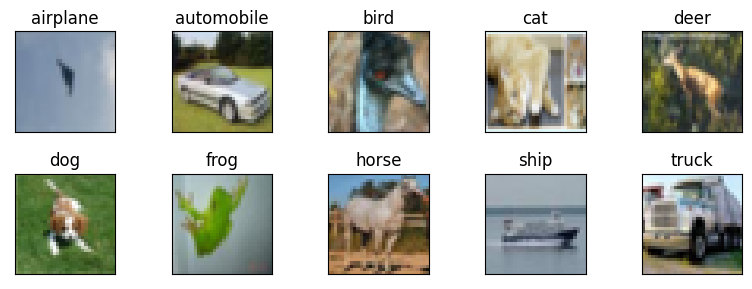

In [5]:

from numpy import zeros
from numpy import ones
from numpy.random import randn
from numpy.random import randint
from keras.datasets.cifar10 import load_data
from keras.optimizers import Adam
from keras.models import Sequential,Model
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.layers import Input
from keras.utils import plot_model, np_utils
from matplotlib import pyplot as plt
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.utils import to_categorical, plot_model
########################################################################



num_classes = len(np.unique(y_train))
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = plt.subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(y_train[:]==i)[0]
    features_idx = x_train[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    img = features_idx[img_num,::]
    ax.set_title(class_names[i])
    plt.imshow(img)
    
plt.tight_layout()


# Trying out GAN for CIFAR-10 
> ## How do Gans Work?

>GANs try to replicate a probability distribution. They should therefore use loss functions that reflect the distance between the distribution of the data generated by the GAN and the distribution of the real data.

## Discriminator built

In [6]:


#############################################################################
#Define generator, discriminator, gan and other helper functions
#Using Sequential method from Keras as it makes the definition of models easy.
#We will use functional way of defining the model for the conditional gan
#but sequential for descriminator and generator as they are straightforward.
#########################################################################

# define the standalone discriminator model
#Given an input image, the Discriminator outputs the likelihood of the image being real.
#Binary classification - true or false (1 or 0). So using sigmoid activation.
def define_discriminator(in_shape=(32,32,3)):
	model = Sequential()
	
	model.add(Conv2D(128, (3,3), strides=(2,2), padding='same', input_shape=in_shape)) #16x16x128
	model.add(LeakyReLU(alpha=0.2))
	
	model.add(Conv2D(128, (3,3), strides=(2,2), padding='same')) #8x8x128
	model.add(LeakyReLU(alpha=0.2))
	
	model.add(Flatten()) #shape of 8192
	model.add(Dropout(0.4))
	model.add(Dense(1, activation='sigmoid')) #shape of 1
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
	return model

test_discr = define_discriminator()
print(test_discr.summary())


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 16, 16, 128)       3584      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 16, 16, 128)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 128)         147584    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dropout (Dropout)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 1)                 8

c:\Users\Xavier\anaconda3\envs\gpu_env_2\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [7]:
plot_model(define_discriminator())

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


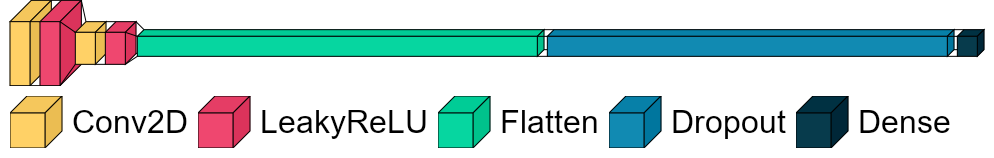

In [8]:

font = ImageFont.truetype("arial.ttf", 32)  # using comic sans is strictly prohibited!
visualkeras.layered_view(define_discriminator(), legend=True, font=font)  # font is optional!


## Generator built

In [9]:

# define the standalone generator model
# #Given input of latent vector, the Generator produces an image.(here: 32x32)
#latent_dim, for example, can be 100, 1D array of size 100 

#Here we are only using Dense and conv2dlayers. But network can be complicated based
#on the application. For example, you can use VGG for super res. GAN.       

def define_generator(latent_dim):    #latent_dim is the dimension of the latent vector (e.g., 100)
	model = Sequential()
	# We will reshape input latent vector into 8x8 image as a starting point. 
    #So n_nodes for the Dense layer can be 128x8x8 so when we reshape the output 
    #it would be 8x8x128 and that can be slowly upscaled to 32x32 image for output.
	n_nodes = 128 * 8 * 8  #8192 nodes
	model.add(Dense(n_nodes, input_dim=latent_dim)) #Dense layer so we can work with 1D latent vector
	model.add(LeakyReLU(alpha=0.2))
	model.add(Reshape((8, 8, 128)))  #8x8x128 dataset from the latent vector. 
	# upsample to 16x16
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')) #16x16x128
	model.add(LeakyReLU(alpha=0.2))
	# upsample to 32x32
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')) #32x32x128
	model.add(LeakyReLU(alpha=0.2))
	# generate
	model.add(Conv2D(3, (8,8), activation='tanh', padding='same')) #32x32x3
	return model  #Model not compiled as it is not directly trained like the discriminator.
                    #Generator is trained via GAN combined model. 

test_gen = define_generator(100)
print(test_gen.summary())



Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 8192)              827392    
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 8192)              0         
                                                                 
 reshape (Reshape)           (None, 8, 8, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 16, 16, 128)      262272    
 nspose)                                                         
                                                                 
 leaky_re_lu_7 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 32, 32, 128)      262272    
 ranspose)                                            

In [12]:
plot_model(define_generator(latent_dim=100))

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


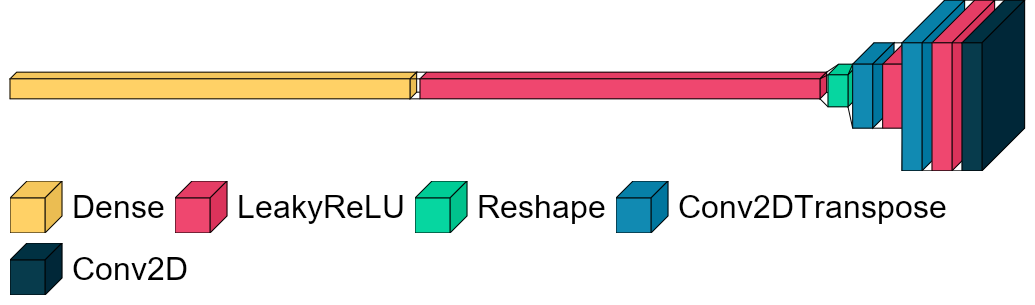

In [13]:

font = ImageFont.truetype("arial.ttf", 32)  # using comic sans is strictly prohibited!
visualkeras.layered_view(define_generator(100), legend=True, font=font)  # font is optional!


## Training the GAN

In [14]:

# define the combined generator and discriminator model, for updating the generator
#Discriminator is trained separately so here only generator will be trained by keeping
#the discriminator constant. 
def define_gan(generator, discriminator):
	discriminator.trainable = False  #Discriminator is trained separately. So set to not trainable.
	# connect generator and discriminator
	model = Sequential()
	model.add(generator)
	model.add(discriminator)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model
	

# load cifar training images
def load_real_samples():
	(x_train, _), (_, _) = load_data()
	# cConvert to float and scale.
	X = x_train.astype('float32')
	# scale from [0,255] to [-1,1]
	X = (X - 127.5) / 127.5  #Generator uses tanh activation so rescale 
                            #original images to -1 to 1 to match the output of generator.
	return X

# pick a batch of random real samples to train the GAN
#In fact, we will train the GAN on a half batch of real images and another 
#half batch of fake images. 
#For each real image we assign a label 1 and for fake we assign label 0. 
def generate_real_samples(dataset, n_samples):
	# choose random images
	ix = randint(0, dataset.shape[0], n_samples)
	# select the random images and assign it to X
	X = dataset[ix]
	# generate class labels and assign to y
	y = ones((n_samples, 1)) ##Label=1 indicating they are real
	return X, y

# generate n_samples number of latent vectors as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input

# use the generator to generate n fake examples, with class labels
#Supply the generator, latent_dim and number of samples as input.
#Use the above latent point generator to generate latent points. 
def generate_fake_samples(generator, latent_dim, n_samples):
	# generate points in latent space
	x_input = generate_latent_points(latent_dim, n_samples)
	# predict using generator to generate fake samples. 
	X = generator.predict(x_input)
	# Class labels will be 0 as these samples are fake. 
	y = zeros((n_samples, 1))  #Label=0 indicating they are fake
	return X, y

def summarize_performance(step, g_model, latent_dim, n_samples=100):
    X, _ = generate_fake_samples(g_model, latent_dim, n_samples)
    X = (X + 1) / 2.0
    for i in range(100):
        plt.subplot(10, 10, 1 + i)
        plt.axis('off')
        plt.imshow(X[i, :, :, 0], cmap='gray_r')

# train the generator and discriminator
#We loop through a number of epochs to train our Discriminator by first selecting
#a random batch of images from our true/real dataset.
#Then, generating a set of images using the generator. 
#Feed both set of images into the Discriminator. 
#Finally, set the loss parameters for both the real and fake images, as well as the combined loss. 

def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=128):
	bat_per_epo = int(dataset.shape[0] / n_batch)
	half_batch = int(n_batch / 2)  #the discriminator model is updated for a half batch of real samples 
                            #and a half batch of fake samples, combined a single batch. 
	# manually enumerate epochs and bacthes. 
	for i in range(n_epochs):
		# enumerate batches over the training set
		for j in range(bat_per_epo):
            
            # Train the discriminator on real and fake images, separately (half batch each)
        #Research showed that separate training is more effective. 
			# get randomly selected 'real' samples
			X_real, y_real = generate_real_samples(dataset, half_batch)
   
			# update discriminator model weights
            ##train_on_batch allows you to update weights based on a collection 
            #of samples you provide
            #Let us just capture loss and ignore accuracy value (2nd output below)
			d_loss_real, _ = d_model.train_on_batch(X_real, y_real) 
			
            # generate 'fake' examples
			X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
			# update discriminator model weights
			d_loss_fake, _ = d_model.train_on_batch(X_fake, y_fake)
            
            #d_loss = 0.5 * np.add(d_loss_real, d_loss_fake) #Average loss if you want to report single..
            
			# prepare points in latent space as input for the generator
			X_gan = generate_latent_points(latent_dim, n_batch)
             
            # The generator wants the discriminator to label the generated samples
			# as valid (ones)
			#This is where the generator is trying to trick discriminator into believing
			#the generated image is true (hence value of 1 for y)			
			y_gan = ones((n_batch, 1))
            
            # Generator is part of combined model where it got directly linked with the discriminator
        # Train the generator with latent_dim as x and 1 as y. 
        # Again, 1 as the output as it is adversarial and if generator did a great
        #job of folling the discriminator then the output would be 1 (true)
			# update the generator via the discriminator's error
			g_loss = gan_model.train_on_batch(X_gan, y_gan)
			
            # Print losses on this batch
			print('Epoch>%d, Batch %d/%d, d1=%.3f, d2=%.3f g=%.3f' %
				(i+1, j+1, bat_per_epo, d_loss_real, d_loss_fake, g_loss))
		#print images for every 10th epoch
		if (i+1) % 10 == 0:
			summarize_performance(i, g_model, d_model, dataset, latent_dim)

	# save the generator model
	g_model.save('./model/cifar_gan_test.h5')


In [15]:
latent_dim = 100
# create the discriminator
discriminator = define_discriminator()
# create the generator
generator = define_generator(latent_dim)
# create the gan
gan_model = define_gan(generator, discriminator)
plot_model(gan_model, show_shapes=True)

c:\Users\Xavier\anaconda3\envs\gpu_env_2\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [18]:

###################################################################
#Train the GAN

# size of the latent space

# load image data
dataset = load_real_samples()
# train model
train(generator, discriminator, gan_model, dataset, latent_dim, n_epochs=100)

################################################################################

# Now, let us load the generator model and generate images

from keras.models import load_model
from numpy.random import randn


# Plot generated images 
def show_plot(examples, n):
	for i in range(n * n):
		plt.subplot(n, n, 1 + i)
		plt.axis('off')
		plt.imshow(examples[i, :, :, :])
	plt.show()


2/2 [==============================] - 0s 231ms/step
Epoch>1, Batch 1/390, d1=0.201, d2=0.447 g=1.055
2/2 [==============================] - 0s 184ms/step
Epoch>1, Batch 2/390, d1=0.177, d2=0.455 g=1.037
2/2 [==============================] - 0s 123ms/step
Epoch>1, Batch 3/390, d1=0.176, d2=0.460 g=1.026
2/2 [==============================] - 0s 188ms/step
Epoch>1, Batch 4/390, d1=0.118, d2=0.467 g=1.024
2/2 [==============================] - 0s 148ms/step


KeyboardInterrupt: 

In [ ]:

# load model
model = load_model('./model/cifar_gan_test.h5') #Model trained for 100 epochs
# generate images
latent_points = generate_latent_points(100, 25)  #Latent dim and n_samples
# generate images
X = model.predict(latent_points)
# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0

# convert to unsigned integers for viewing
X = (X*255).astype(np.uint8)


1/1 [==============================] - 5s 5s/step


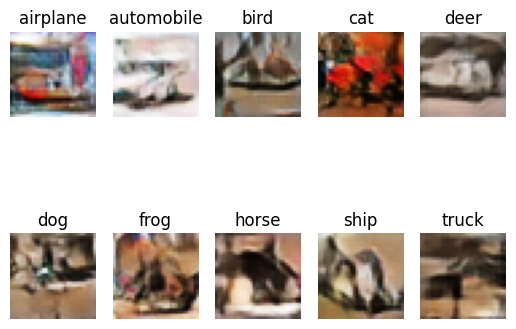

In [ ]:
# plot the result according to classes
classes = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']
for i in range(10):
    plt.subplot(2, 5, 1 + i)
    plt.axis('off')
    plt.imshow(X[i])
    plt.title(classes[i])


# Definition collection

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard, TerminateOnNaN, CSVLogger

from tensorflow.image import random_flip_left_right, random_crop, resize_with_crop_or_pad
BATCH_SIZE = 128 #@param {type:"number"}
IMG_SIZE = (32, 32, 3) #@param {type:"number"}
def load_data_cifar():
  (x_train, y_train), (x_test, y_test) = load_data()
  train_size = 40000
  x_train, y_train, x_val, y_val = x_train[:train_size], y_train[:train_size], x_train[train_size:], y_train[train_size:]
  return x_train, y_train, x_val, y_val, x_test, y_test

def preprocess_data(x_train, y_train, x_val, y_val, x_test, y_test):
  x_train = x_train.astype('float32')
  x_train /= 127.5
  x_train -= 1
  
  x_val = x_val.astype('float32')
  x_val = x_val / 127.5
  x_val -= 1
  
  y_train = to_categorical(y_train)
  y_val = to_categorical(y_val)
  y_test = to_categorical(y_test)
  return x_train, y_train, x_val, y_val, x_test, y_test

def plot_loss_curve(model_history):
  model_history = pd.DataFrame(model_history)
  epochs = list(range(1, len(model_history) + 1))
  fig = go.Figure()
  fig.add_trace(go.Scatter(x=epochs, y=model_history["loss"],
                    mode='lines+markers',
                    name='Training Loss'))
  fig.add_trace(go.Scatter(x=epochs, y=model_history["val_loss"],
                    mode='lines+markers',
                    name='Validation Loss'))
  fig.add_trace(go.Scatter(x=epochs, y=model_history["accuracy"],
                    mode="lines+markers",
                    name="Training Accuracy"))
  fig.add_trace(go.Scatter(x=epochs, y=model_history["val_accuracy"],
                           mode="lines+markers",
                           name="Validation Accuracy"))
  fig.update_layout(
    title="Loss/Acc Plot",
    xaxis_title="Epochs",
    yaxis_title="Loss/Acc",
)

  return fig
def basic_data_aug(images):
 image = random_flip_left_right(images) 
 image = resize_with_crop_or_pad(image, IMG_SIZE[0] + 4, IMG_SIZE[1] + 4)
 image = random_crop(
     image, size=IMG_SIZE
 )
 return image

def set_up_data_aug(x_train,y_train,x_val,y_val,aug_func=basic_data_aug):
  train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
  val_ds = tf.data.Dataset.from_tensor_slices((x_val, y_val)).shuffle(BATCH_SIZE * 100).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
  train_ds = train_ds.map(
      lambda x, y : (aug_func(x), y), num_parallel_calls=tf.data.AUTOTUNE
  ).shuffle(BATCH_SIZE * 100).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
  return train_ds, val_ds

class ModelEvaluator:
  """
  A class to keep track of experiments made, so that it is easier to keep track of experimentation
  """
  def __init__(self, history_path = None, base_savedir = "/content/drive/MyDrive/Data/DELE CA1/CIFAR10"):
    if history_path is None:
      self.result_history = pd.DataFrame({
          "Model Name" : [],
          "Epochs" : [],
          "Batch Size" : [],
          "Train Loss" : [],
          "Test Loss" : [],
          "Train Acc" : [],
          "Test Acc" : [],
          "Remarks" : [],
          "Model Path" : []
      })
    else:
      self.result_history = pd.read_csv(history_path, sep=";")
    self.default_callbacks = [
                                  TerminateOnNaN(),
                                  CSVLogger("/tmp/training.log", append=False)
    ]
    self.base_savedir = base_savedir
    
    #training_data = train_ds, validation_data = val_ds, hyperparameters =base_hparams
  def evaluate_model(self, model, training_data, validation_data, hyperparameters , callbacks = None, plot_loss = True, remarks = "", savedir = None):
    """
    Evaluate a model. Assumes the model has already been compiled, so compilation and choice of optimizer must be done beforehand
    """
    # Train Model
    if callbacks is None:
      callbacks = [EarlyStopping(monitor='val_accuracy',patience=20, restore_best_weights=True)]
    callbacks = self.default_callbacks + callbacks
    name = model.name
    validation_split = hyperparameters["val_split"]
    epochs = hyperparameters["max_epochs"]
    batch_size = hyperparameters["batch_size"]
    if savedir is None:
      filepath = f"{self.base_savedir}/SavedModels/{name}"
    else:
      filepath = savedir
    print(f"Training {name}")
    try:
      if validation_data is None:
        x_train, y_train = training_data
        history = model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=validation_split,callbacks=callbacks)
      else:
        history = model.fit(training_data, validation_data=validation_data, epochs=epochs, batch_size=batch_size,callbacks=callbacks)
      history = history.history
      # print(history)
    except KeyboardInterrupt:
      history = pd.read_csv("/tmp/training.log")
      # print(history)
      print("\nHalting Training")
    print(f"Saving best model to {filepath}")
    if plot_loss:
      try:
        fig = plot_loss_curve(history)
      except:
        print("error creating loss curve")
        fig = None
    else:
      fig = None
    result = dict()
    result["Epochs"] = len(history["loss"])
    result["Batch Size"] = batch_size
    result["Model Name"] = name
    result["Remarks"] = remarks
    result["Model Path"] = filepath
    # Calculate Statistics
    best_val_idx = np.argmax(history["val_accuracy"])
    result["Train Loss"] = history["loss"][best_val_idx]
    result["Test Loss"] = history["val_loss"][best_val_idx]
    result["Train Acc"] = history["accuracy"][best_val_idx]
    result["Test Acc"] = history["val_accuracy"][best_val_idx]
    result["[Train - Test] Acc"] = result["Train Acc"] - result["Test Acc"]
    self.result_history = self.result_history.append(result, ignore_index=True)
    tf.keras.backend.clear_session() # clear all previous models from memory
    return pd.Series(result), fig
  def return_model(self, model_name):
    filepath = self.result_history[
                                   self.result_history["Model Name"] == model_name
    ]["Model Path"]
    assert len(filepath) == 1, "There is no model or more than one model with that name!"
    filepath = filepath.values[0]
    model = tf.keras.models.load_model(filepath)
    return model

  def return_history(self, include_cols = ['Model Name', 'Train Acc', 'Test Acc', '[Train - Test] Acc', 'Remarks'] ):
    return self.result_history[include_cols]

  # def return_training_logs(self, model_name):
  #   raise NotImplementedError

  # def return_loss_plot(self, model_name):
  #   raise NotImplementedError
  #   logs = return_training_logs(model_name)
  #   return plot_loss_curve(logs)
  def remove_model(self, model_name):
    mask = ~(self.result_history["Model Name"] == model_name)
    self.result_history = self.result_history[mask]
  def add_remarks(self, model_name, comment):
    """
    Add comments to a model result
    Comments can include:
      - Sources of Error
      - Notes about model architecture
    """
    mask = (self.result_history["Model Name"] == model_name)
    assert mask.sum() == 1, "There is no model or more than one model with that name!"
    self.result_history.loc[mask, "Remarks"] = comment

  def save_history(self, file_name = None):
    if file_name is None:
      file_name = f"{self.base_savedir}/history.csv"
    self.result_history.to_csv(file_name, sep=";", index=False)
    print(f"History saved to {file_name}")
    
class ModelEvaluator:
  """
  A class to keep track of experiments made, so that it is easier to keep track of experimentation
  """
  def __init__(self, history_path = None, base_savedir = "./data_aug"):
    if history_path is None:
      self.result_history = pd.DataFrame({
          "Model Name" : [],
          "Epochs" : [],
          "Batch Size" : [],
          "Train Loss" : [],
          "Test Loss" : [],
          "Train Acc" : [],
          "Test Acc" : [],
          "Remarks" : [],
          "Model Path" : []
      })
    else:
      self.result_history = pd.read_csv(history_path, sep=";")
    self.default_callbacks = [
                                  TerminateOnNaN(),
                                  CSVLogger("/tmp/training.log", append=False)
    ]
    self.base_savedir = base_savedir
    
    #evaluate_model params (training_data = train_ds, validation_data = val_ds, hyperparameters = base_hparams) 
    
  def evaluate_model(self, model, training_data , validation_data , hyperparameters , callbacks = None, plot_loss = True, remarks = "", savedir = None):
    """
    Evaluate a model. Assumes the model has already been compiled, so compilation and choice of optimizer must be done beforehand
    """
    # Train Model
    if callbacks is None:
      callbacks = [EarlyStopping(monitor='val_accuracy',patience=20, restore_best_weights=True)]
    callbacks = self.default_callbacks + callbacks
    name = model.name
    validation_split = hyperparameters["val_split"]
    epochs = hyperparameters["max_epochs"]
    batch_size = hyperparameters["batch_size"]
    if savedir is None:
      filepath = f"{self.base_savedir}/SavedModels/{name}"
    else:
      filepath = savedir
    print(f"Training {name}")
    try:
      if validation_data is None:
        X_train, y_train = training_data
        history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=validation_split,callbacks=callbacks)
      else:
        history = model.fit(training_data, validation_data=validation_data, epochs=epochs, batch_size=batch_size,callbacks=callbacks)
      history = history.history
      # print(history)
    except KeyboardInterrupt:
      history = pd.read_csv("/tmp/training.log")
      # print(history)
      print("\nHalting Training")
    print(f"Saving best model to {filepath}")
    if plot_loss:
      try:
        fig = plot_loss_curve(history)
      except:
        print("error creating loss curve")
        fig = None
    else:
      fig = None
    result = dict()
    result["Epochs"] = len(history["loss"])
    result["Batch Size"] = batch_size
    result["Model Name"] = name
    result["Remarks"] = remarks
    result["Model Path"] = filepath
    # Calculate Statistics
    best_val_idx = np.argmax(history["val_accuracy"])
    result["Train Loss"] = history["loss"][best_val_idx]
    result["Test Loss"] = history["val_loss"][best_val_idx]
    result["Train Acc"] = history["accuracy"][best_val_idx]
    result["Test Acc"] = history["val_accuracy"][best_val_idx]
    result["[Train - Test] Acc"] = result["Train Acc"] - result["Test Acc"]
    self.result_history = self.result_history.append(result, ignore_index=True)
    tf.keras.backend.clear_session() # clear all previous models from memory
    return pd.Series(result), fig
  def return_model(self, model_name):
    filepath = self.result_history[
                                   self.result_history["Model Name"] == model_name
    ]["Model Path"]
    assert len(filepath) == 1, "There is no model or more than one model with that name!"
    filepath = filepath.values[0]
    model = tf.keras.models.load_model(filepath)
    return model

  def return_history(self, include_cols = ['Model Name', 'Train Acc', 'Test Acc', '[Train - Test] Acc', 'Remarks'] ):
    return self.result_history[include_cols]

  # def return_training_logs(self, model_name):
  #   raise NotImplementedError

  # def return_loss_plot(self, model_name):
  #   raise NotImplementedError
  #   logs = return_training_logs(model_name)
  #   return plot_loss_curve(logs)
  def remove_model(self, model_name):
    mask = ~(self.result_history["Model Name"] == model_name)
    self.result_history = self.result_history[mask]
  def add_remarks(self, model_name, comment):
    """
    Add comments to a model result
    Comments can include:
      - Sources of Error
      - Notes about model architecture
    """
    mask = (self.result_history["Model Name"] == model_name)
    assert mask.sum() == 1, "There is no model or more than one model with that name!"
    self.result_history.loc[mask, "Remarks"] = comment

  def save_history(self, file_name = None):
    if file_name is None:
      file_name = f"{self.base_savedir}/history.csv"
    self.result_history.to_csv(file_name, sep=";", index=False)
    print(f"History saved to {file_name}")


# Tuning
* Change Latent Space. Update the example to use a larger or smaller latent space and compare the quality of the results and speed of training.
* Batch Normalization. Update the discriminator and/or the generator to make use of batch normalization, recommended for DCGAN models.
* Label Smoothing. Update the example to use one-sided label smoothing when training the discriminator, specifically change the target label of real examples from 1.0 to 0.9 and add random noise, then review the effects on image quality and speed of training.
* Model Configuration. Update the model configuration to use deeper or more shallow discriminator and/or generator models, perhaps experiment with the UpSampling2D layers in the generator.
* Experience Replay 

# Measure Performance
How do you capture the difference between two distributions in GAN loss functions? This question is an area of active research, and many approaches have been proposed. We'll address two common GAN loss functions here, both of which are implemented in TF-GAN:

* minimax loss: The loss function used in the paper that introduced GANs.
* Wasserstein loss: The default loss function for TF-GAN Estimators. First described in a 2017 paper.
* FID scores
  
TF-GAN implements many other loss functions as well.

# Trying out CGAN
>In cGANs, a conditional setting is applied, meaning that both the generator and discriminator are conditioned on some sort of auxiliary information (such as class labels or data) from other modalities. As a result, the ideal model can learn multi-modal mapping from inputs to outputs by being fed with different contextual information.

* By providing additional information, we get two benefits:

* Convergence will be faster. Even the random distribution that the fake images follow will have some pattern.
* You can control the output of the generator at test time by giving the label for the image you want to generate.

## Defining hyperparameters and loading data

In [6]:
# Hyperparameters and Constants
latent_dim = 128
channels = 3
nclasses = 10
img_shape = (32, 32, 3)
discriminator_in_channels = 13

In [7]:
def preprocessing_func(x, y):
    # pixel normalization
    x = x.astype('float32')
    x /= 127.5
    x -= 1
    y = to_categorical(y=y, num_classes=10)

    return x, y

x_train, y_train = preprocessing_func(x_train, y_train)
x_test, y_test = preprocessing_func(x_test, y_test)

## Building Generator


In [8]:
# latent noise vector z
from keras.layers import *
z = Input(shape=(128,), name="Latent_Noise_Vector_z")

# conditions y
conditions = Input(shape=(10,), name='Conditions_y')

# Generator network
merged_layer = Concatenate()([z, conditions])

# FC: 2x2x512
generator = Dense(2*2*512, activation='relu')(merged_layer)
generator = BatchNormalization(momentum=0.9)(generator)
generator = LeakyReLU(alpha=0.1)(generator)
generator = Reshape((2, 2, 512))(generator)

base_generator = Sequential([
    # Conv 1: 4x4x256
    Conv2DTranspose(256, kernel_size=4, strides=2, padding='same'),
    BatchNormalization(momentum=0.9),
    LeakyReLU(alpha=0.1),
    # Conv 2: 8x8x128
    Conv2DTranspose(128, kernel_size=4, strides=2, padding='same'),
    BatchNormalization(momentum=0.9),
    LeakyReLU(alpha=0.1),
    # Conv 3: 16x16x64
    Conv2DTranspose(64, kernel_size=4, strides=2, padding='same'),
    BatchNormalization(momentum=0.9),
    LeakyReLU(alpha=0.1),
], name='Base_Generator')
generator = base_generator(generator)

# Conv 4: 32x32x3
generator = Conv2DTranspose(3, kernel_size=4, strides=2, padding='same', activation='tanh', name='Output_Layer')(generator)

generator = Model(inputs=[z, conditions], outputs=generator, name='generator')

generator.summary()

Model: "generator"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Latent_Noise_Vector_z (InputLa  [(None, 128)]       0           []                               
 yer)                                                                                             
                                                                                                  
 Conditions_y (InputLayer)      [(None, 10)]         0           []                               
                                                                                                  
 concatenate (Concatenate)      (None, 138)          0           ['Latent_Noise_Vector_z[0][0]',  
                                                                  'Conditions_y[0][0]']           
                                                                                          

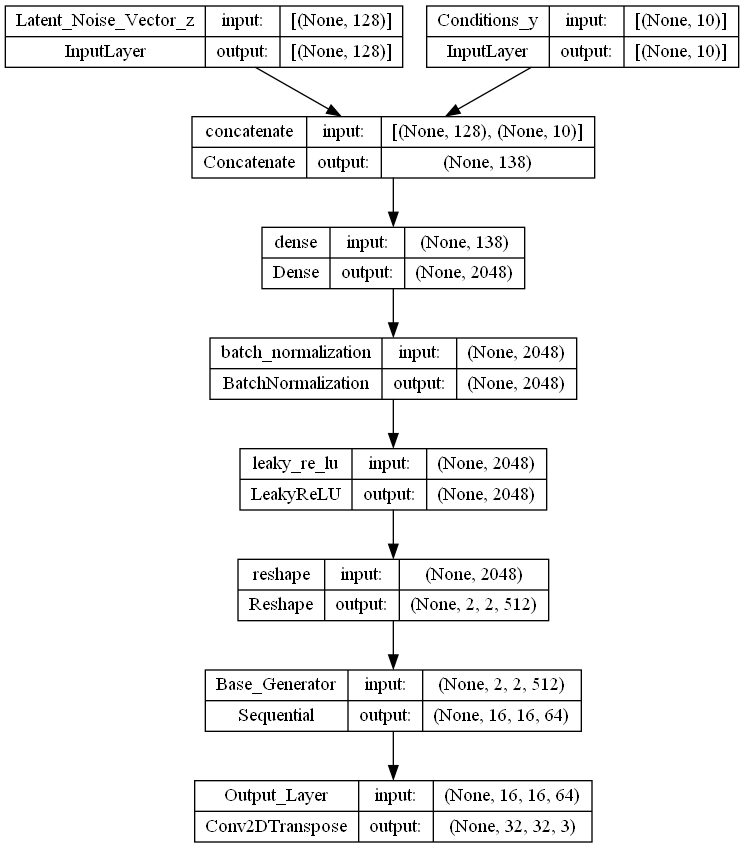

In [9]:
plot_model(generator, show_shapes=True)

## Building Discriminator

In [10]:
# input image
img_input = Input(shape=(x_train[0].shape), name='Image_Input')

# conditions y
conditions = Input(shape=(10,), name='Conditions_y')

base_discriminator = Sequential([
    # 16x16x64
    Conv2D(64, kernel_size=4, strides=2, padding='same'),
    BatchNormalization(momentum=0.9),
    LeakyReLU(alpha=0.1),
    # 8x8x128
    Conv2D(128, kernel_size=4, strides=2, padding='same'),
    BatchNormalization(momentum=0.9),
    LeakyReLU(alpha=0.1),
    # 4x4x256
    Conv2D(256, kernel_size=4, strides=2, padding='same'),
    BatchNormalization(momentum=0.9),
    LeakyReLU(alpha=0.1),
    # 2x2x512
    Conv2D(512, kernel_size=4, strides=2, padding='same'),
    BatchNormalization(momentum=0.9),
    LeakyReLU(alpha=0.1),
], name='Base_Discriminator')
discriminator = base_discriminator(img_input)

# Feature Extraction via GAP: 512
discriminator = GlobalAveragePooling2D()(discriminator)

# Concatenate - combine with conditions y
merged_layer = Concatenate()([discriminator, conditions])
discriminator = Dense(512, activation='relu')(merged_layer)
    
# Output
discriminator = Dense(1, activation='sigmoid', name='Output_Layer')(discriminator)

discriminator = Model(inputs=[img_input, conditions], outputs=discriminator, name='discriminator')

discriminator.summary()

Model: "discriminator"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Image_Input (InputLayer)       [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 Base_Discriminator (Sequential  (None, 2, 2, 512)   2760384     ['Image_Input[0][0]']            
 )                                                                                                
                                                                                                  
 global_average_pooling2d (Glob  (None, 512)         0           ['Base_Discriminator[0][0]']     
 alAveragePooling2D)                                                                              
                                                                                      

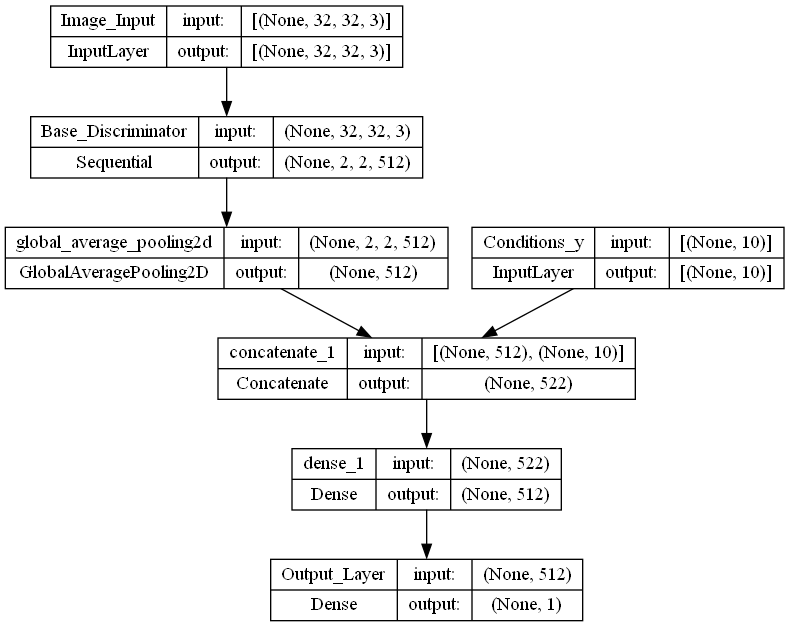

In [11]:
plot_model(discriminator, show_shapes=True)

## Building CGAN

In [12]:
class ConditionalGAN(tf.keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(ConditionalGAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.gen_loss_tracker = tf.keras.metrics.Mean(name="generator_loss")
        self.disc_loss_tracker = tf.keras.metrics.Mean(name="discriminator_loss")
        self.d_xy_tracker = tf.keras.metrics.Mean(name='Mean D(x|y)')
        self.d_g_zy_tracker = tf.keras.metrics.Mean(name='Mean D(G(z|y))')
        self.kl = tf.keras.metrics.KLDivergence()

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(ConditionalGAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    def train_step(self, data):
        ### TRAINING DISCRIMINATOR ###
        # Unpack the data.
        real_images, condition = data
        
        # Sample for latent noise vector z
        batch_size = tf.shape(real_images)[0]
        latent_noise_vector = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Maps the noise latent vector and labels to generate fake images.
        generated_images = self.generator([latent_noise_vector, condition])

        # Combine with real images
        combined_images = tf.concat([generated_images, real_images], axis=0)
        combined_condition = tf.concat([condition, condition], axis=0)

        # Discrimination
        labels = tf.concat(
            [tf.zeros((batch_size, 1)), tf.ones((batch_size, 1))], axis=0
        )

        # Train the discriminator.
        with tf.GradientTape() as tape:
            first_predictions = self.discriminator([combined_images, combined_condition])
            d_loss = self.loss_fn(labels, first_predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Computing D(x|y)
        d_xy = tf.math.reduce_mean(first_predictions)

        ### TRAINING GENRATOR ###
        latent_noise_vector = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Assemble labels that say "all real images".
        misleading_labels = tf.ones((batch_size, 1))

        with tf.GradientTape() as tape:
            fake_images = self.generator([latent_noise_vector, condition])
            second_predictions = self.discriminator([fake_images, condition])        
            g_loss = self.loss_fn(misleading_labels, second_predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Computing D(G(z|y))
        d_g_zy = tf.math.reduce_mean(second_predictions)

        # Monitor loss and metrics.
        self.gen_loss_tracker.update_state(g_loss)
        self.disc_loss_tracker.update_state(d_loss)
        self.d_xy_tracker.update_state(d_xy)
        self.d_g_zy_tracker.update_state(d_g_zy)
        self.kl.update_state(real_images, fake_images)

        return {
            "d_loss": self.disc_loss_tracker.result(),
            "g_loss": self.gen_loss_tracker.result(),
            "D(x|y)": self.d_xy_tracker.result(),
            "D(G(z|y))": self.d_g_zy_tracker.result(),
            "KL Divergence": self.kl.result(),
        }

## Creating a call-back function

In [13]:
import keras 
latent_dim = 128
class GANMonitor(keras.callbacks.Callback):
    # class GANMontor
    # - num_img: number of images generated using matplotlib figure
    # - latent_dim: dimensions of noise latent vector passed into the generator
    # - patience: number of epochs to generate images
    # - vmin: minumum scaling factor, a
    # - vmax: maximum scaling factor, b
    # NOTE: only compatible with the GAN class I've set up
    def __init__(self, num_img=20, latent_dim=128, patience=10, vmin=0, vmax=1):
        self.num_img = num_img
        self.latent_dim = latent_dim
        self.patience = patience
        self.vmin = vmin
        self.vmax = vmax


        # making the latent vec
        self.latent_noise_vector = tf.random.normal(shape=(self.num_img, self.latent_dim))
        self.conditions = to_categorical([0, 1, 2, 3, 4, 5, 6, 7, 8, 9,
                                 0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

    # method to generate images and display them as matplotlib figure
    def generate_plot(self):
        # Generate Images
        generated_images = self.model.generator.predict([self.latent_noise_vector, self.conditions])

        # Normalise Image from [vmin, vmax] to [0, 1]
        generated_images -= self.vmin
        generated_images /= (self.vmax - self.vmin)

        # Generate Matplotlib Figure
        row_size = np.ceil(self.num_img/5)
        fig = plt.figure(figsize=(10, 2*row_size), tight_layout=True)
        for i in range(self.num_img):
            ax = fig.add_subplot(int(row_size), 5, i+1)
            ax.imshow(generated_images[i])
            ax.set_title(classes[i%10])
            ax.axis('off')
        plt.show()

    # method to save generator's weights
    def save_weights(self, epoch=None):
        try:
            if epoch != None:
                name='./model/cgan/generator-epoch-{}.h5'.format(epoch)
                print('Generator Checkpoint - {}'.format(name))
                self.model.generator.save_weights(
                    filepath=name,
                    save_format='h5'
                )
        except Exception as e:
            print(e)

    # generate a plot every n epochs
    def on_epoch_begin(self, epoch, logs=None):
        if epoch % self.patience == 0:
            self.generate_plot()
            self.save_weights(epoch)

    # generate a plot after training
    def on_train_end(self, epoch, logs=None):
        self.generate_plot()
        self.save_weights('Full Train')
# List of Callback Functions
callbacks = [
    GANMonitor(num_img=20, latent_dim=128, patience=5, vmin=-1, vmax=1),
]

# Creating a cGAN class
cond_gan = ConditionalGAN(
    discriminator=discriminator, 
    generator=generator, 
    latent_dim=latent_dim
)
# Compiling with Optimizer and Loss Function
cond_gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5),
    loss_fn=keras.losses.BinaryCrossentropy(),
)

## Training the model without data augmentation

1/1 [==============================] - 1s 653ms/step


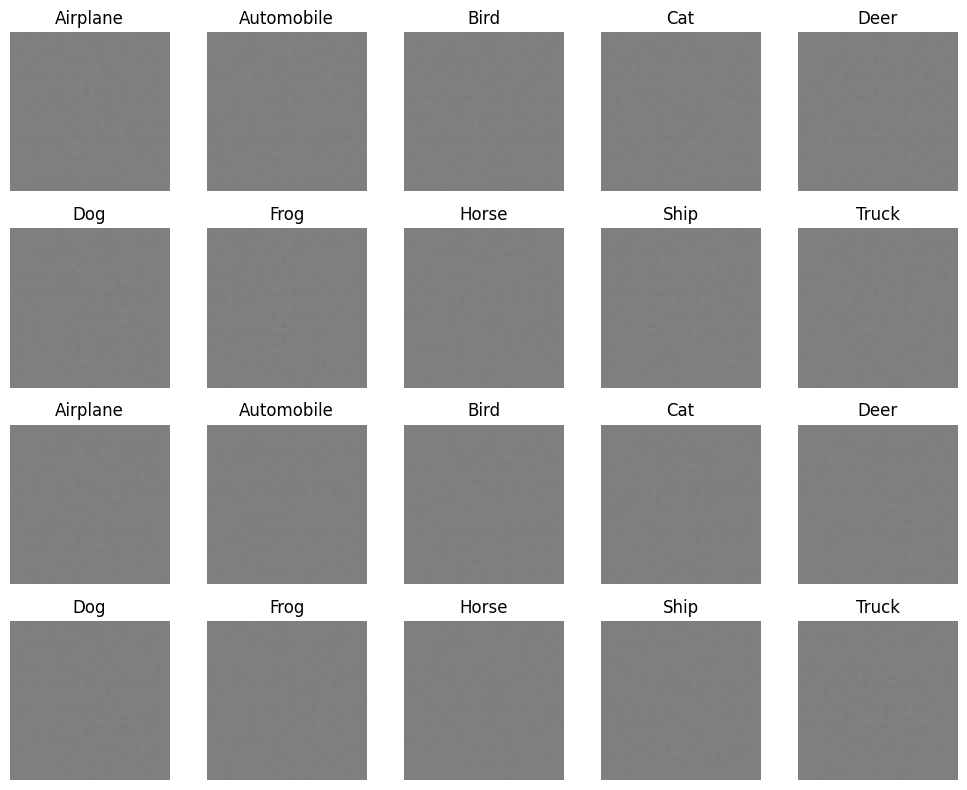

Generator Checkpoint - ./model/cgan/generator-epoch-0.h5
[Errno 2] Unable to create file (unable to open file: name = './model/cgan/generator-epoch-0.h5', errno = 2, error message = 'No such file or directory', flags = 13, o_flags = 302)
Epoch 1/100
166/782 [=====>........................] - ETA: 10:40 - d_loss: 0.4829 - g_loss: 1.3364 - D(x|y): 0.6358 - D(G(z|y)): 0.3493 - KL Divergence: 6.0537

In [14]:

# Preparing the Dataset with `tf.data`
batch_size = 64
dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
dataset = dataset.shuffle(buffer_size=1024).batch(batch_size, num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)

# Starting the Train Process
hist = cond_gan.fit(dataset, epochs=100, use_multiprocessing=True, workers=16, callbacks=callbacks)

### Plotting the results

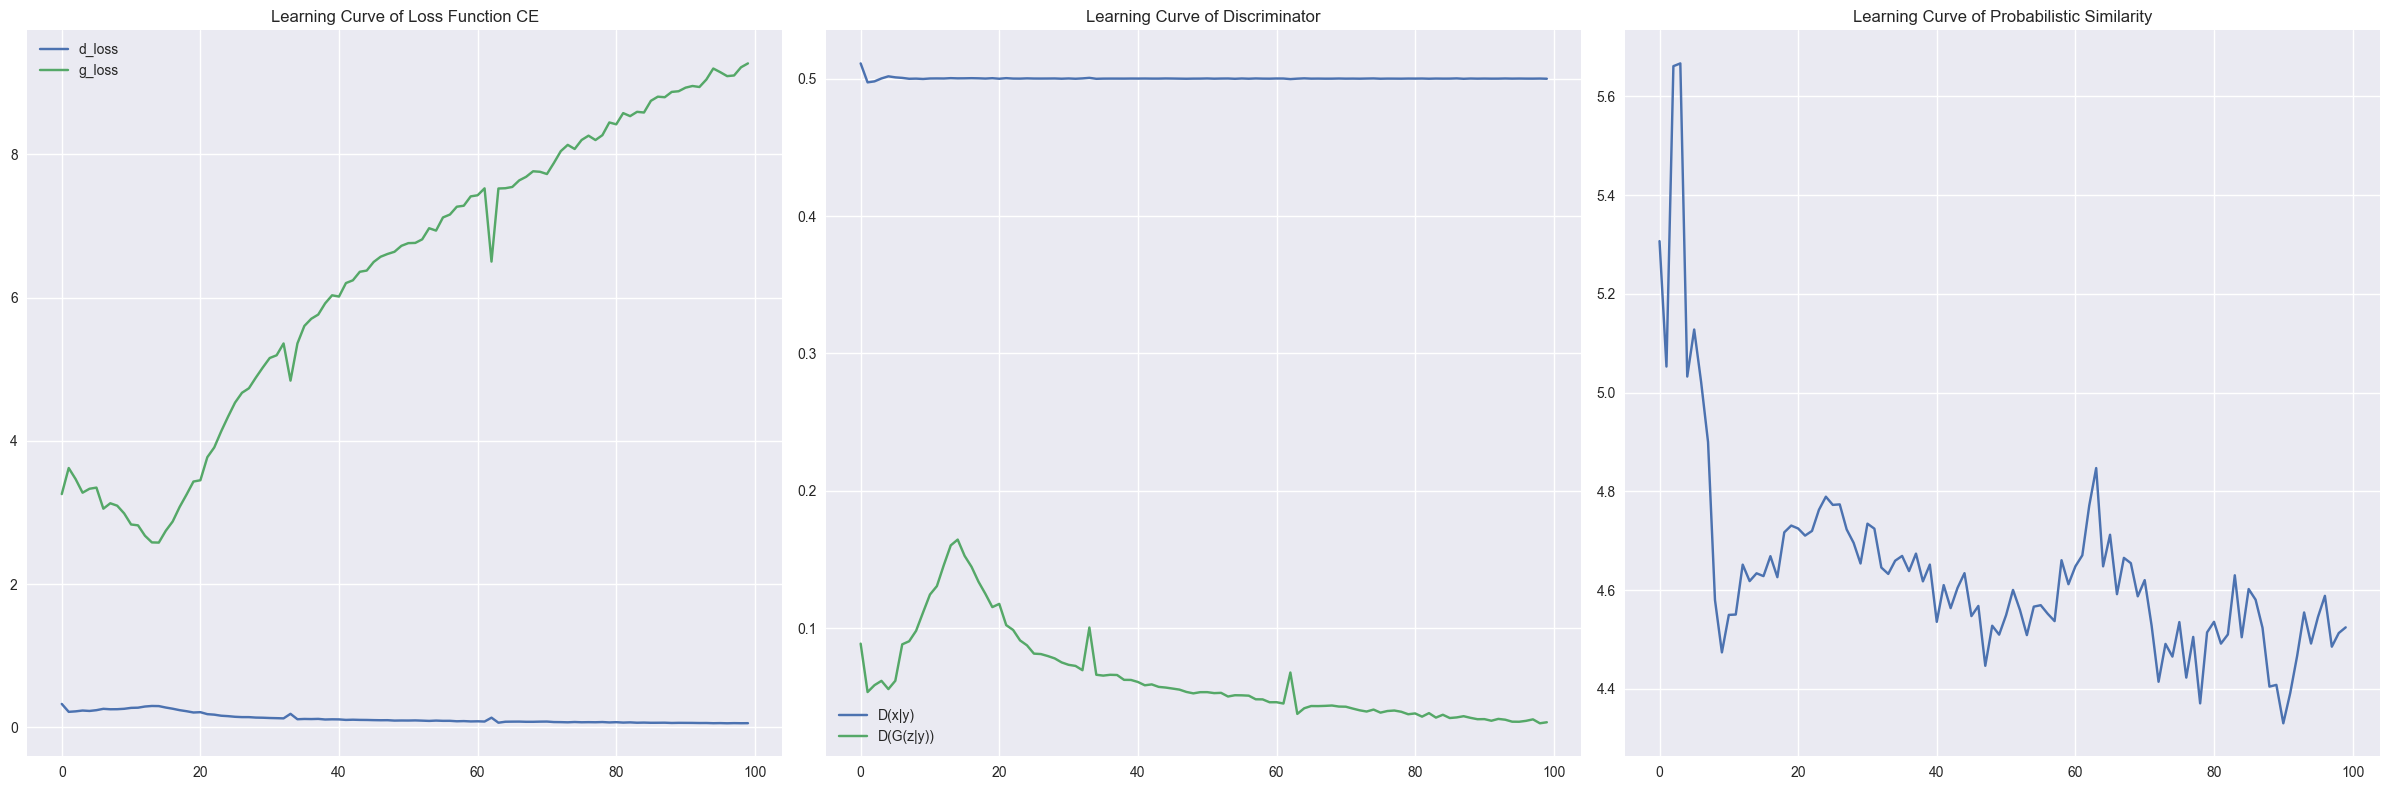

In [ ]:
# story history object into dataframe
hist_df = pd.DataFrame(hist.history)

# using pandas dataframe to plot out learning curve
with plt.style.context('seaborn'):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 8), tight_layout=True)
    hist_df.loc[:, ["d_loss", 'g_loss']].plot(ax=ax1, title=r'Learning Curve of Loss Function CE')
    hist_df.loc[:, ['D(x|y)', 'D(G(z|y))']].plot(ax=ax2, title=r'Learning Curve of Discriminator')
    hist_df.loc[:,'KL Divergence'].plot(ax=ax3, title=r'Learning Curve of Probabilistic Similarity')
    plt.show()

### Evaluation of full trainned model

In [ ]:
# Loading Weights for best Generator
saved_weights = './model/cgan/generator-epoch-Full-Train.h5'
cond_gan.generator.load_weights(saved_weights)
cond_gan.generator.summary()

Model: "generator"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Latent_Noise_Vector_z (InputLa  [(None, 128)]       0           []                               
 yer)                                                                                             
                                                                                                  
 Conditions_y (InputLayer)      [(None, 10)]         0           []                               
                                                                                                  
 concatenate (Concatenate)      (None, 138)          0           ['Latent_Noise_Vector_z[0][0]',  
                                                                  'Conditions_y[0][0]']           
                                                                                          

32/32 [==============================] - 8s 6ms/step
Latent Vector Dim: (1024, 128)	Generated Images Dim: (1024, 32, 32, 3)


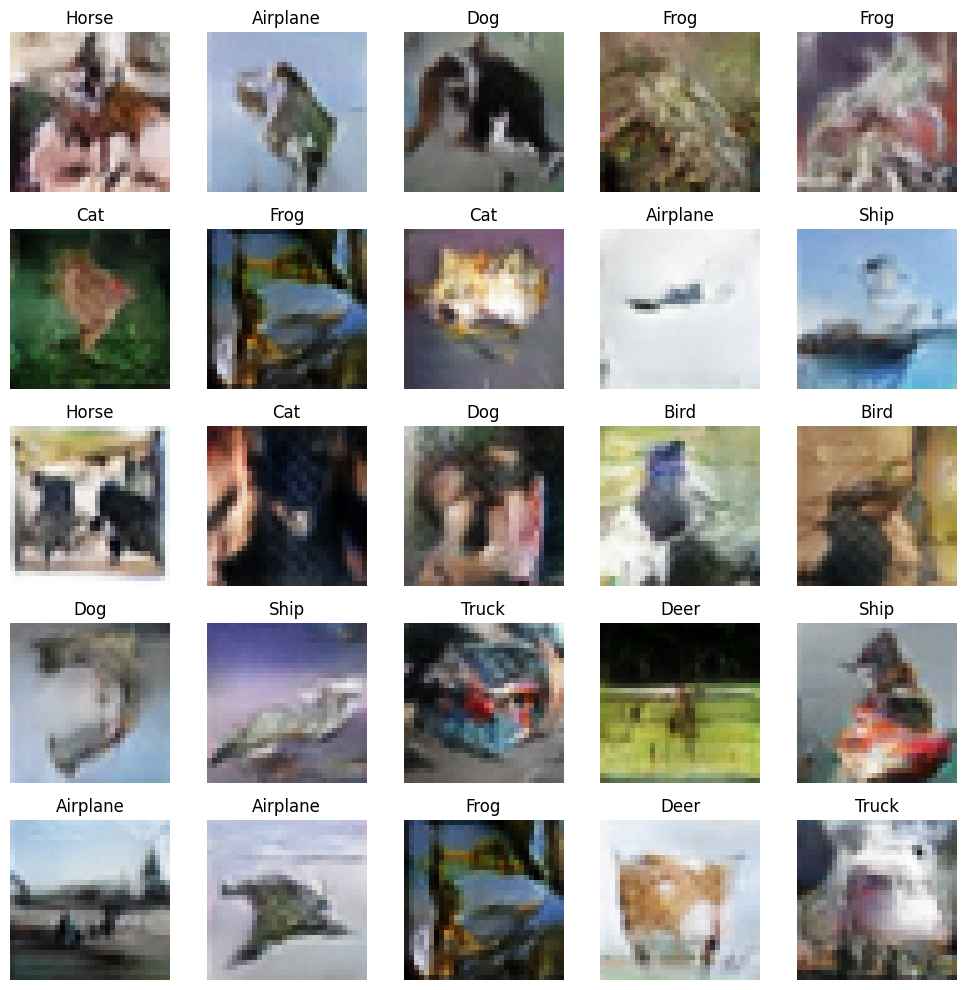

In [ ]:
n = 1024

# generating labels
labels = np.random.randint(low=0, high=10, size=n)
one_hot_labels = to_categorical(labels)

# Generating 1000 Synthetic Images
random_noise = tf.random.normal(shape=(n, latent_dim))

synthetic_images = cond_gan.generator.predict([random_noise, one_hot_labels])
print("Latent Vector Dim: {}\tGenerated Images Dim: {}".format(random_noise.shape, synthetic_images.shape))

# Scaling back to [0, 1]
synthetic_images -= -1
synthetic_images /= (1 - (-1))

# Display 25 randomly sampled images
fig = plt.figure(figsize=(10, 10), tight_layout=True)
for i in range(25):
    rand_idx = np.random.randint(0, len(synthetic_images))
    ax = fig.add_subplot(5, 5, i+1)
    ax.imshow(synthetic_images[rand_idx])
    ax.set_title(classes[labels[rand_idx]])
    ax.axis('off')
plt.show()

### Evaluation using Fréchet Inception Distance (FID)

In [ ]:
import numpy as np
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from scipy.linalg import sqrtm
import math
from tqdm import tqdm
from tensorflow.image import resize
class GAN_FID:
    def __init__(self, batch_size, latent_dim, sample_size, buffer_size):
        # setting Hyperparameters
        self.BATCH_SIZE = batch_size
        self.LATENT_DIM = latent_dim
        self.SAMPLE_SIZE = sample_size
        self.BUFFER_SIZE = buffer_size

        # setting Constants
        self.INCEPTION_SHAPE = (299, 299, 3)
        self.INCEPTION = InceptionV3(include_top=False, pooling='avg', input_shape=self.INCEPTION_SHAPE)
        self.AUTO = tf.data.AUTOTUNE

    # method to set generator and training data
    def fit(self, generator, train_data):
        # setting generative model and original data used for training 
        self.GENERATOR = generator
        self.train_data = train_data

        # Preparing Real Images
        trainloader = tf.data.Dataset.from_tensor_slices((self.train_data))
        trainloader = (
            trainloader
            .shuffle(self.BUFFER_SIZE)
            .map(self.__resize_and_preprocess, num_parallel_calls=self.AUTO)
            .batch(self.BATCH_SIZE, num_parallel_calls=self.AUTO)
            .prefetch(self.AUTO)
        )
        self.trainloader = trainloader

        # Generate and prepare Synthetic Images (Fake)
        rand_labels = np.random.randint(low=0, high=10, size=self.SAMPLE_SIZE)
        rand_labels = to_categorical(rand_labels)
        noise = tf.random.normal([self.SAMPLE_SIZE, self.LATENT_DIM])

        generated_images = self.GENERATOR([noise, rand_labels])
        genloader = tf.data.Dataset.from_tensor_slices(generated_images)
        genloader = (
            genloader
            .map(self.__resize_and_preprocess, num_parallel_calls=self.AUTO)
            .batch(self.BATCH_SIZE, num_parallel_calls=self.AUTO)
            .prefetch(self.AUTO)
        )
        self.genloader = genloader

        # prepare embeddings
        count = math.ceil(self.SAMPLE_SIZE/self.BATCH_SIZE)

        ## compute embeddings for real images
        print("Computing Real Image Embeddings")
        self.real_image_embeddings = self.__compute_embeddings(self.trainloader, count)

        ## compute embeddings for generated images
        print("Computing Generated Image Embeddings")
        self.generated_image_embeddings = self.__compute_embeddings(self.genloader, count)
        assert self.real_image_embeddings.shape == self.generated_image_embeddings.shape, "Embeddings are not of the same size"
        print("Computed Embeddings\tReal Images Embedding Shape: {}\tGenerated Images Embedding Shape".format(
            self.real_image_embeddings.shape, 
            self.generated_image_embeddings.shape
        ))
    
    # method to produce evaluation results
    @tf.autograph.experimental.do_not_convert
    def evaluate(self):
        # calculate Frechet Inception Distance
        fid = self.__calculate_fid(self.real_image_embeddings, self.generated_image_embeddings)
        print('The computed FID score is:', fid)

        return fid

    # method to generate embeddings from inception model 
    def __compute_embeddings(self, dataloader, count):
        image_embeddings = []
        for _ in tqdm(range(count)):
            images = next(iter(dataloader))
            embeddings = self.INCEPTION.predict(images)
            image_embeddings.extend(embeddings)
        return np.array(image_embeddings)

    ## STATIC METHODS: these methods knows nothing about the class
    # static method to prepare the data before computing Inception Embeddings
    @staticmethod
    def __resize_and_preprocess(image):
        # image *= 255.0 # original image are scaled to [0, 1], scaling back to [0, 255]
        image -= -1
        image /= (1 - (-1))
        image *= 255.

        # .preprocess_input() expects an image of scale [0, 255]
        image = preprocess_input(image)
        # inception model expects an image of shape (None, 299, 299, 3)
        image = tf.image.resize(image, (299, 299), method='nearest')
        return image

    # static method to calculate frechet inception distance based on embeddings
    @staticmethod 
    def __calculate_fid(real_embeddings, generated_embeddings):
        # calculate mean and covariance statistics
        mu1, sigma1 = real_embeddings.mean(axis=0), np.cov(real_embeddings, rowvar=False)
        mu2, sigma2 = generated_embeddings.mean(axis=0), np.cov(generated_embeddings, rowvar=False)
        # calculate sum squared difference between means
        ssdiff = np.sum((mu1 - mu2)**2.0)
        # calculate sqrt of product between cov
        covmean = sqrtm(sigma1.dot(sigma2))
        # check and correct imaginary numbers from sqrt
        if np.iscomplexobj(covmean):
            covmean = covmean.real
        # calculate score
        fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
        return fid

In [ ]:
x_train, y_train, x_val, y_val, x_test, y_test = load_data_cifar()
x_train, y_train, x_val, y_val, x_test, y_test = preprocess_data(x_train, y_train, x_val, y_val, x_test, y_test)

In [ ]:
fid_class = GAN_FID(batch_size=512, latent_dim=128, sample_size=10000, buffer_size=1024)
fid_class.fit(generator=cond_gan.generator, train_data=x_train)
fid_score = fid_class.evaluate()


Exception ignored in: <function tqdm.__del__ at 0x000001949D3A0940>
Traceback (most recent call last):
  File "c:\Users\Xavier\anaconda3\envs\gpu_env_2\lib\site-packages\tqdm\std.py", line 1162, in __del__
    self.close()
  File "c:\Users\Xavier\anaconda3\envs\gpu_env_2\lib\site-packages\tqdm\notebook.py", line 288, in close
    self.disp(bar_style='danger', check_delay=False)
AttributeError: 'tqdm_notebook' object has no attribute 'disp'
Exception ignored in: <function tqdm.__del__ at 0x000001949D3A0940>
Traceback (most recent call last):
  File "c:\Users\Xavier\anaconda3\envs\gpu_env_2\lib\site-packages\tqdm\std.py", line 1162, in __del__
    self.close()
  File "c:\Users\Xavier\anaconda3\envs\gpu_env_2\lib\site-packages\tqdm\notebook.py", line 288, in close
    self.disp(bar_style='danger', check_delay=False)
AttributeError: 'tqdm_notebook' object has no attribute 'disp'


Computing Real Image Embeddings


  0%|          | 0/20 [00:00<?, ?it/s]

16/16 [==============================] - 37s 2s/step


  5%|▌         | 1/20 [00:39<12:31, 39.57s/it]

16/16 [==============================] - 41s 3s/step


 10%|█         | 2/20 [01:22<12:28, 41.57s/it]

16/16 [==============================] - 47s 3s/step


 15%|█▌        | 3/20 [02:12<12:48, 45.23s/it]

16/16 [==============================] - 78s 5s/step


 20%|██        | 4/20 [03:35<16:04, 60.31s/it]

16/16 [==============================] - 37s 2s/step


 25%|██▌       | 5/20 [04:15<13:15, 53.03s/it]

16/16 [==============================] - 58s 4s/step


 30%|███       | 6/20 [05:16<12:57, 55.55s/it]

16/16 [==============================] - 38s 2s/step


 35%|███▌      | 7/20 [05:57<11:03, 51.02s/it]

16/16 [==============================] - 35s 2s/step


 40%|████      | 8/20 [06:36<09:24, 47.07s/it]

16/16 [==============================] - 42s 3s/step


 45%|████▌     | 9/20 [07:31<09:04, 49.49s/it]

16/16 [==============================] - 41s 2s/step


 50%|█████     | 10/20 [08:15<07:58, 47.82s/it]

16/16 [==============================] - 29s 2s/step


 55%|█████▌    | 11/20 [08:46<06:25, 42.83s/it]

16/16 [==============================] - 29s 2s/step


 60%|██████    | 12/20 [09:17<05:13, 39.22s/it]

16/16 [==============================] - 28s 2s/step


 65%|██████▌   | 13/20 [09:47<04:14, 36.39s/it]

16/16 [==============================] - 28s 2s/step


 70%|███████   | 14/20 [10:17<03:26, 34.38s/it]

16/16 [==============================] - 28s 2s/step


 75%|███████▌  | 15/20 [10:47<02:45, 33.02s/it]

16/16 [==============================] - 28s 2s/step


 80%|████████  | 16/20 [11:16<02:07, 31.85s/it]

16/16 [==============================] - 28s 2s/step


 85%|████████▌ | 17/20 [11:45<01:33, 31.15s/it]

16/16 [==============================] - 28s 2s/step


 90%|█████████ | 18/20 [12:15<01:01, 30.67s/it]

16/16 [==============================] - 32s 2s/step


 95%|█████████▌| 19/20 [12:49<00:31, 31.66s/it]

16/16 [==============================] - 31s 2s/step


100%|██████████| 20/20 [13:22<00:00, 40.15s/it]


Computing Generated Image Embeddings


  0%|          | 0/20 [00:00<?, ?it/s]

16/16 [==============================] - 31s 2s/step


  5%|▌         | 1/20 [00:33<10:33, 33.35s/it]

16/16 [==============================] - 31s 2s/step


 10%|█         | 2/20 [01:05<09:50, 32.82s/it]

16/16 [==============================] - 30s 2s/step


 15%|█▌        | 3/20 [01:37<09:10, 32.35s/it]

16/16 [==============================] - 31s 2s/step


 20%|██        | 4/20 [02:09<08:37, 32.34s/it]

16/16 [==============================] - 30s 2s/step


 25%|██▌       | 5/20 [02:42<08:05, 32.36s/it]

16/16 [==============================] - 30s 2s/step


 30%|███       | 6/20 [03:14<07:30, 32.19s/it]

16/16 [==============================] - 31s 2s/step


 35%|███▌      | 7/20 [03:46<07:00, 32.37s/it]

16/16 [==============================] - 30s 2s/step


 40%|████      | 8/20 [04:18<06:27, 32.26s/it]

16/16 [==============================] - 31s 2s/step


 45%|████▌     | 9/20 [04:51<05:55, 32.33s/it]

16/16 [==============================] - 31s 2s/step


 50%|█████     | 10/20 [05:24<05:26, 32.62s/it]

16/16 [==============================] - 30s 2s/step


 55%|█████▌    | 11/20 [05:56<04:51, 32.43s/it]

16/16 [==============================] - 30s 2s/step


 60%|██████    | 12/20 [06:28<04:18, 32.25s/it]

16/16 [==============================] - 30s 2s/step


 65%|██████▌   | 13/20 [07:00<03:45, 32.21s/it]

16/16 [==============================] - 30s 2s/step


 70%|███████   | 14/20 [07:32<03:13, 32.23s/it]

16/16 [==============================] - 30s 2s/step


 75%|███████▌  | 15/20 [08:04<02:40, 32.13s/it]

16/16 [==============================] - 30s 2s/step


 80%|████████  | 16/20 [08:36<02:08, 32.13s/it]

16/16 [==============================] - 31s 2s/step


 85%|████████▌ | 17/20 [09:09<01:36, 32.30s/it]

16/16 [==============================] - 542s 36s/step


 90%|█████████ | 18/20 [18:12<06:11, 185.81s/it]

16/16 [==============================] - 33s 2s/step


 95%|█████████▌| 19/20 [18:49<02:20, 140.89s/it]

16/16 [==============================] - 32s 2s/step


100%|██████████| 20/20 [19:23<00:00, 58.15s/it] 


Computed Embeddings	Real Images Embedding Shape: (10240, 2048)	Generated Images Embedding Shape
The computed FID score is: 556.8699456161273


## Training the model with data augmentation

In [ ]:
x_train, y_train, x_val, y_val, x_test, y_test = load_data_cifar()
x_train, y_train, x_val, y_val, x_test, y_test = preprocess_data(x_train, y_train, x_val, y_val, x_test, y_test)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


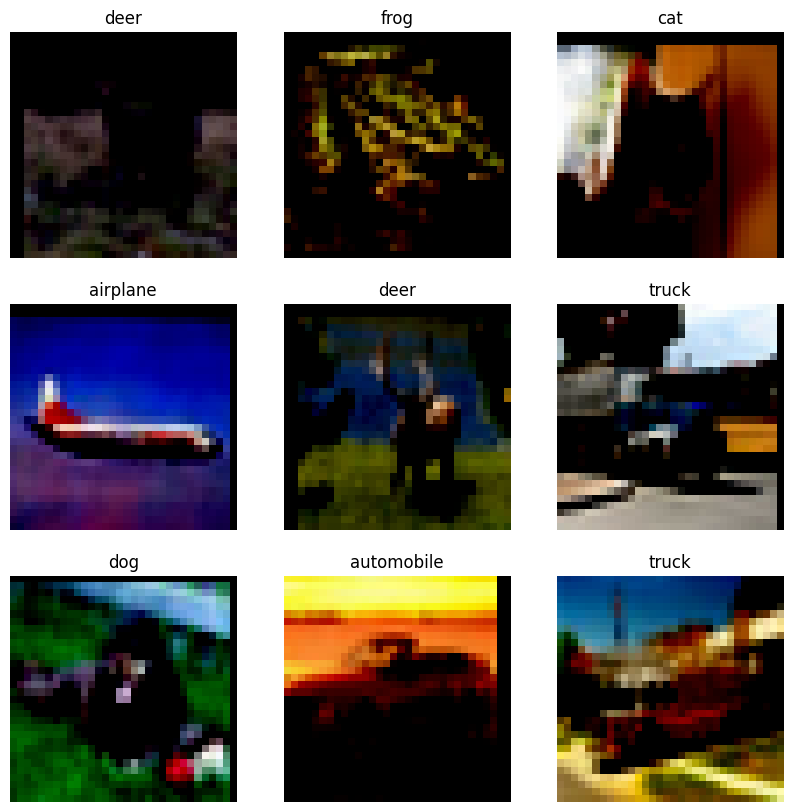

In [ ]:
#initialise data augmentation
def set_up_data_aug(aug_func=basic_data_aug):
  train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
  val_ds = tf.data.Dataset.from_tensor_slices((x_val, y_val)).shuffle(BATCH_SIZE * 100).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
  train_ds = train_ds.map(
      lambda x, y : (aug_func(x), y), num_parallel_calls=tf.data.AUTOTUNE
  ).shuffle(BATCH_SIZE * 100).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
  return train_ds, val_ds

train_aug_ds, val_ds = set_up_data_aug()
train_ds, val_ds = set_up_data_aug(lambda x : x) # apply no data aug
image_batch, label_batch = next(iter(train_aug_ds))

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.title(class_names[np.argmax(label_batch[i])])
    plt.imshow(tf.squeeze(image_batch[i]))
    plt.axis("off")

In [ ]:
from keras.optimizers import SGD, Adam
#@title Base Hyperparameters
LR = 0.05 #@param {type:"number"}
momentum = 0.9 #@param {type:"number"}
WEIGHT_DECAY = 0.0005 #@param {type:"number"}
MAX_EPOCHS = 200 #@param {type:"integer"}
VAL_SPLIT = 0.2
base_hparams = {
    "val_split" : VAL_SPLIT,
    "max_epochs" : MAX_EPOCHS,
    "batch_size" : BATCH_SIZE
}
from math import ceil
steps_per_epoch = ceil(len(x_train)/ BATCH_SIZE)
lr_scheduler = tf.keras.optimizers.schedules.CosineDecayRestarts(
    LR,
    steps_per_epoch * 10 # found to work well for CIFAR10 with shorter training time
)
optimizer = SGD(
    learning_rate = lr_scheduler,
    momentum = momentum
)

In [ ]:
# Preparing the Dataset with `tf.data`
batch_size = 64
dataset = tf.data.Dataset.from_tensor_slices((train_ds, y_train))
dataset = dataset.shuffle(buffer_size=1024).batch(batch_size, num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)

# Starting the Train Process
hist = cond_gan.fit(dataset, epochs=100, use_multiprocessing=True, workers=16, callbacks=callbacks)


ValueError: Slicing dataset elements is not supported for rank 0.

# Trying out DCGAN
>DCGAN is a Deep Convolutional Generative Adversarial network that uses Deep Conv Nets to have a stable architecture and better results. The Generator in GAN uses a fully connected network, whereas DCGAN uses a Transposed Convolutional network to upsample the images.

In [ ]:
def define_discriminator(in_shape=(32,32,3)):
    model = Sequential()
    model.add(Conv2D(64, (3,3), padding='same', input_shape=in_shape))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(256, (3,3), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

In [ ]:
from keras.initializers import RandomNormal
def define_generator(latent_dim):
    weights_init = RandomNormal(mean=0, stddev=0.02)

    generator = Sequential([
        # fc block: handling latent vector z
        Input(shape=(latent_dim,)),
        Dense(2*2*512),
        Reshape((2, 2, 512)),

        # Conv 1
        ## using a kernel size that is a factor of the stride
        Conv2DTranspose(256, kernel_size=4, strides=2, padding='same', kernel_initializer=weights_init),
        BatchNormalization(momentum=0.8),
        PReLU(),

        # Conv 2
        Conv2DTranspose(128, kernel_size=4, strides=2, padding='same', kernel_initializer=weights_init),
        BatchNormalization(momentum=0.8),
        PReLU(),

        # Conv 3
        Conv2DTranspose(64, kernel_size=4, strides=2, padding='same', kernel_initializer=weights_init),
        BatchNormalization(momentum=0.8),
        PReLU(),

        # Output Layer
        Conv2DTranspose(3, kernel_size=4, strides=2, padding='same', activation='tanh', kernel_initializer=weights_init)
    ], name='generator_GAN')
    return generator


In [ ]:
# Hyperparameters and Constants
BATCH_SIZE  = 64
LATENT_DIM  = 128
AUTO        = tf.data.AUTOTUNE
EPOCHS      = 100
BUFFER_SIZE = 1024
INPUT_DIM   = (32, 32, 3)

In [ ]:
class GAN(Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.gen_loss_tracker = keras.metrics.Mean(name='generator_loss')
        self.disc_loss_tracker = keras.metrics.Mean(name='discriminator_loss')
        self.kl = tf.keras.metrics.KLDivergence()

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    def train_step(self, real_images):
        ### TRAINING DISCRIMINATOR
        if isinstance(real_images, tuple):
            real_images = real_images[0]
        # Sample random points in the latent space
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Decode them to fake images
        generated_images = self.generator(random_latent_vectors)

        # Combine them with real images
        combined_images = tf.concat([generated_images, real_images], axis=0)

        # Assemble labels discriminating real from fake images
        labels = tf.concat(
            [tf.zeros((batch_size, 1)), tf.ones((batch_size, 1))], axis=0
        )
        # Add random noise to the labels - important trick!
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        ### TRAINING GENERATOR
        # Sample random points in the latent space
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Assemble labels that say "all real images"
        misleading_labels = tf.ones((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            generated_images = self.generator(random_latent_vectors)
            predictions = self.discriminator(generated_images)
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Monitor Loss
        self.disc_loss_tracker.update_state(d_loss)
        self.gen_loss_tracker.update_state(g_loss)
        self.kl.update_state(y_true=real_images, y_pred=generated_images)
        
        return {
            "d_loss": self.disc_loss_tracker.result(), 
            "g_loss": self.gen_loss_tracker.result(), 
            "KL Divergence": self.kl.result(),
        }

In [ ]:
# Custom callback to monitor the Generator at every n epoch
class GANMonitor(keras.callbacks.Callback):
    # class GANMontor
    # - num_img: number of images generated using matplotlib figure
    # - latent_dim: dimensions of noise latent vector passed into the generator
    # - patience: number of epochs to generate images
    # - vmin: minumum scaling factor, a
    # - vmax: maximum scaling factor, b
    # NOTE: only compatible with the GAN class I've set up
    def __init__(self, num_img=10, latent_dim=128, patience=10, vmin=0, vmax=1):
        self.num_img = num_img
        self.latent_dim = latent_dim
        self.patience = patience
        self.vmin = vmin
        self.vmax = vmax
        self.constant_latent_vector = tf.random.normal(shape=(self.num_img, self.latent_dim))

    # method to generate images and display them as matplotlib figure
    def generate_plot(self):
        # Generate Images
        generated_images = self.model.generator(self.constant_latent_vector)

        # Normalise Image from [vmin, vmax] to [0, 1]
        generated_images -= self.vmin
        generated_images /= (self.vmax - self.vmin)

        # Generate Matplotlib Figure
        row_size = np.ceil(self.num_img/5)
        fig = plt.figure(figsize=(10, 2*row_size), tight_layout=True)
        for i in range(self.num_img):
            ax = fig.add_subplot(row_size, 5, i+1)
            ax.imshow(generated_images[i])
            ax.axis('off')
        plt.show()

    # method to save generator's weights
    def save_weights(self, epoch=None):
        try:
            if epoch != None:
                name='./model/dcgan/generator-epoch-{}.h5'.format(epoch)
                print('Generator Checkpoint - {}'.format(name))
                self.model.generator.save_weights(
                    filepath=name,
                    save_format='h5'
                )
        except Exception as e:
            print(e)

    # generate a plot every n epochs
    def on_epoch_begin(self, epoch, logs=None):
        if epoch % self.patience == 0:
            self.generate_plot()
            self.save_weights(epoch)

    # generate a plot after training
    def on_train_end(self, epoch, logs=None):
        self.generate_plot()
        self.save_weights('Full Train')

In [ ]:
gan = GAN(
    discriminator=define_discriminator(), 
    generator=define_generator(latent_dim=LATENT_DIM), 
    latent_dim=latent_dim
)
# Compiling with Optimizer and Loss Function
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
    g_optimizer=keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
    loss_fn=keras.losses.BinaryCrossentropy(),
)

c:\Users\Xavier\anaconda3\envs\gpu_env\lib\site-packages\keras\initializers\initializers_v2.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


In [ ]:
dataset = tf.data.Dataset.from_tensor_slices(x_train)
dataset = dataset.shuffle(buffer_size=BUFFER_SIZE).batch(batch_size=BATCH_SIZE, num_parallel_calls=AUTO).prefetch(AUTO)

# Starting the Train Process
hist = gan.fit(dataset, epochs=EPOCHS, use_multiprocessing=True, workers=16, callbacks=callbacks)

ValueError: in user code:

    File "c:\Users\Xavier\anaconda3\envs\gpu_env\lib\site-packages\keras\engine\training.py", line 2041, in predict_function  *
        return step_function(self, iterator)
    File "c:\Users\Xavier\anaconda3\envs\gpu_env\lib\site-packages\keras\engine\training.py", line 2027, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\Xavier\anaconda3\envs\gpu_env\lib\site-packages\keras\engine\training.py", line 2015, in run_step  **
        outputs = model.predict_step(data)
    File "c:\Users\Xavier\anaconda3\envs\gpu_env\lib\site-packages\keras\engine\training.py", line 1983, in predict_step
        return self(x, training=False)
    File "c:\Users\Xavier\anaconda3\envs\gpu_env\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\Xavier\anaconda3\envs\gpu_env\lib\site-packages\keras\engine\input_spec.py", line 216, in assert_input_compatibility
        raise ValueError(

    ValueError: Layer "generator_GAN" expects 1 input(s), but it received 2 input tensors. Inputs received: [<tf.Tensor 'IteratorGetNext:0' shape=(None, 128) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(None, 10) dtype=float32>]


In [ ]:
def load_real_samples():
    (trainX, _), (_, _) = load_data()
    X = trainX.astype('float32')
    X = (X - 127.5) / 127.5
    return X
def generate_real_samples(dataset, n_samples):
    ix = randint(0, dataset.shape[0], n_samples)
    X = dataset[ix]
    y = ones((n_samples, 1))
    return X, y
 
def generate_latent_points(latent_dim, n_samples):
    x_input = randn(latent_dim * n_samples)
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input
 
def generate_fake_samples(g_model, latent_dim, n_samples):
    x_input = generate_latent_points(latent_dim, n_samples)
    X = g_model.predict(x_input)
    y = zeros((n_samples, 1))
    return X, y

In [ ]:
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=1000, n_batch=128):
    bat_per_epo = int(dataset.shape[0] / n_batch)
    half_batch = int(n_batch / 2)
    for i in range(n_epochs):
        for j in range(bat_per_epo):
            X_real, y_real = generate_real_samples(dataset, half_batch)
            d_loss1, _ = d_model.train_on_batch(X_real, y_real)
            X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            d_loss2, _ = d_model.train_on_batch(X_fake, y_fake)
            X_gan = generate_latent_points(latent_dim, n_batch)
            y_gan = ones((n_batch, 1))
            g_loss = gan_model.train_on_batch(X_gan, y_gan)
            print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' %
                (i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))

        #print images for every 10th epoch
        if (i+1) % 10 == 0:
            summarize_performance(i, g_model, latent_dim)
            
def save_plot(examples, epoch, n=10):
    for i in range(n * n):
        plt.subplot(n, n, 1 + i)
        plt.axis('off')
        plt.imshow(examples[i, :, :, 0], cmap='gray_r')
    filename = './images/dcgan/generated_plot_e%03d.png' % (epoch+1)
    plt.savefig(filename)
    plt.close()            



In [ ]:
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=150):
    X_real, y_real = generate_real_samples(dataset, n_samples)
    _, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
    x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
    _, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
    print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
    save_plot(x_fake, epoch)
    filename = './model/dcgan/generator_model_%03d.h5' % (epoch+1)
    g_model.save(filename)

In [ ]:
latent_dim = 100
d_model = define_discriminator()
g_model = define_generator(latent_dim)
gan_model = define_gan(g_model, d_model)
dataset = load_real_samples()
hist = train(g_model, d_model, gan_model, dataset, latent_dim)


c:\Users\Xavier\anaconda3\envs\gpu_env\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


AttributeError: 'Sequential' object has no attribute 'generator'

In [ ]:
# story history object into dataframe
hist_df = pd.DataFrame(hist.history)

# using pandas dataframe to plot out learning curve
with plt.style.context('seaborn'):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 8), tight_layout=True)
    hist_df.loc[:, ["d_loss", 'g_loss']].plot(ax=ax1, title=r'Learning Curve of Loss Function CE')
    hist_df.loc[:, ['D(x|y)', 'D(G(z|y))']].plot(ax=ax2, title=r'Learning Curve of Discriminator')
    hist_df.loc[:,'KL Divergence'].plot(ax=ax3, title=r'Learning Curve of Probabilistic Similarity')
    plt.show()

NameError: name 'hist' is not defined

In [ ]:
# using pandas dataframe to plot out learning curve
with plt.style.context('seaborn'):
    for cols in [["d_loss", "g_loss"], ["D(x|y)", "D(G(z|y))"], "KL Divergence"]:
        fig, ax = plt.subplots(1, 1, figsize=(8, 8), tight_layout=True)
        hist_df.loc[:, cols].plot(ax=ax)
        plt.show()

In [ ]:
n = 1024

# generating labels
labels = np.random.randint(low=0, high=10, size=n)
one_hot_labels = to_categorical(labels)

# Generating 1000 Synthetic Images
random_noise = tf.random.normal(shape=(n, latent_dim))

synthetic_images = cond_gan.generator.predict([random_noise, one_hot_labels])
print("Latent Vector Dim: {}\tGenerated Images Dim: {}".format(random_noise.shape, synthetic_images.shape))

# Scaling back to [0, 1]
synthetic_images -= -1
synthetic_images /= (1 - (-1))

# Display 25 randomly sampled images
fig = plt.figure(figsize=(10, 10), tight_layout=True)
for i in range(25):
    rand_idx = np.random.randint(0, len(synthetic_images))
    ax = fig.add_subplot(5, 5, i+1)
    ax.imshow(synthetic_images[rand_idx])
    ax.set_title(classes[labels[rand_idx]])
    ax.axis('off')
plt.show()

# Trying out ACGAN
Auxiliary Classifier Generative Adversarial Network

## Generator Built

In [ ]:
# latent noise vector z
z = Input(shape=(128,), name="Latent_Noise_Vector_z")

# conditions y
conditions = Input(shape=(10,), name='Conditions_y')

# Generator network
merged_layer = Concatenate()([z, conditions])

# FC: 2x2x512
generator = Dense(2*2*512, activation='relu')(merged_layer)
generator = BatchNormalization(momentum=0.9)(generator)
generator = LeakyReLU(alpha=0.1)(generator)
generator = Reshape((2, 2, 512))(generator)

base_generator = Sequential([
    # Conv 1: 4x4x256
    Conv2DTranspose(256, kernel_size=4, strides=2, padding='same'),
    BatchNormalization(momentum=0.9),
    LeakyReLU(alpha=0.1),
    # Conv 2: 8x8x128
    Conv2DTranspose(128, kernel_size=4, strides=2, padding='same'),
    BatchNormalization(momentum=0.9),
    LeakyReLU(alpha=0.1),
    # Conv 3: 16x16x64
    Conv2DTranspose(64, kernel_size=4, strides=2, padding='same'),
    BatchNormalization(momentum=0.9),
    LeakyReLU(alpha=0.1),
], name='Base_Generator')
generator = base_generator(generator)

# Conv 4: 32x32x3
generator = Conv2DTranspose(3, kernel_size=4, strides=2, padding='same', activation='tanh', name='Output_Layer')(generator)

generator = Model(inputs=[z, conditions], outputs=generator, name='generator')

generator.summary()

Model: "generator"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Latent_Noise_Vector_z (InputLa  [(None, 128)]       0           []                               
 yer)                                                                                             
                                                                                                  
 Conditions_y (InputLayer)      [(None, 10)]         0           []                               
                                                                                                  
 concatenate_2 (Concatenate)    (None, 138)          0           ['Latent_Noise_Vector_z[0][0]',  
                                                                  'Conditions_y[0][0]']           
                                                                                          

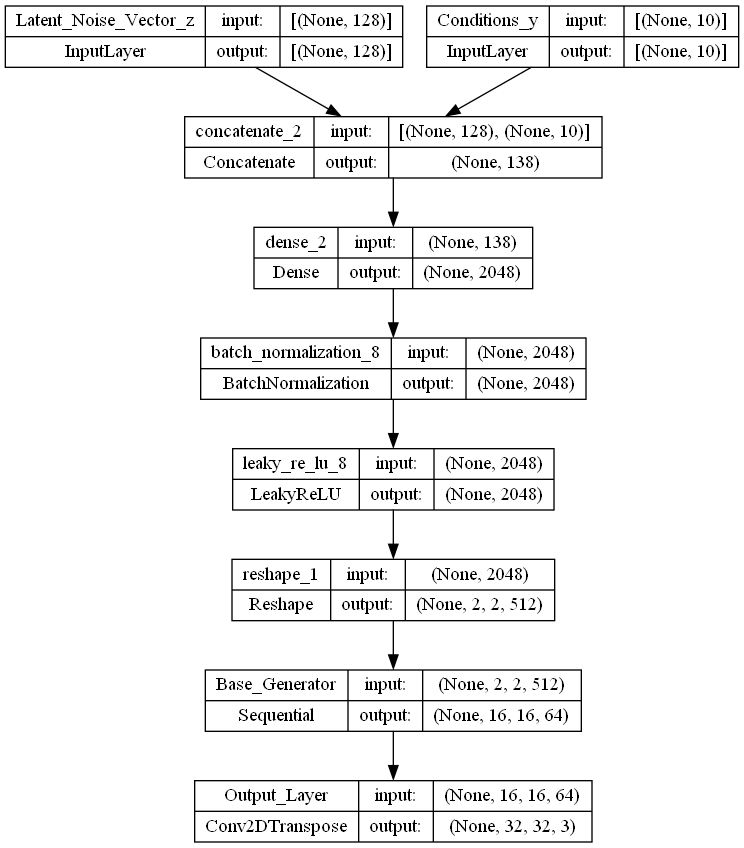

In [ ]:
# visualise model
plot_model(generator, show_shapes=True)

## Discriminator Built

In [ ]:
# input image
img_input = Input(shape=(x_train[0].shape), name='Image_Input')

# conditions y
conditions = Input(shape=(10,), name='Conditions_y')

base_discriminator = Sequential([
    # 16x16x64
    Conv2D(64, kernel_size=4, strides=2, padding='same'),
    BatchNormalization(momentum=0.9),
    LeakyReLU(alpha=0.1),
    # 8x8x128
    Conv2D(128, kernel_size=4, strides=2, padding='same'),
    BatchNormalization(momentum=0.9),
    LeakyReLU(alpha=0.1),
    # 4x4x256
    Conv2D(256, kernel_size=4, strides=2, padding='same'),
    BatchNormalization(momentum=0.9),
    LeakyReLU(alpha=0.1),
    # 2x2x512
    Conv2D(512, kernel_size=4, strides=2, padding='same'),
    BatchNormalization(momentum=0.9),
    LeakyReLU(alpha=0.1),
], name='Base_Discriminator')
discriminator = base_discriminator(img_input)

# Feature Extraction via GAP: 512
discriminator = GlobalAveragePooling2D()(discriminator)

# Concatenate - combine with conditions y
merged_layer = Concatenate()([discriminator, conditions])
discriminator = Dense(512, activation='relu')(merged_layer)
    
# Output
Disc_Output_Layer = Dense(1, activation='sigmoid', name='Disc_Output_Layer')(discriminator)
Aux_Output_Layer = Dense(10, activation='softmax', name='Aux_Output_Layer')(discriminator)

discriminator = Model(inputs=[img_input, conditions], outputs=[Disc_Output_Layer, Aux_Output_Layer], name='discriminator')

discriminator.summary()

Model: "discriminator"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Image_Input (InputLayer)       [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 Base_Discriminator (Sequential  (None, 2, 2, 512)   2760384     ['Image_Input[0][0]']            
 )                                                                                                
                                                                                                  
 global_average_pooling2d_1 (Gl  (None, 512)         0           ['Base_Discriminator[0][0]']     
 obalAveragePooling2D)                                                                            
                                                                                      

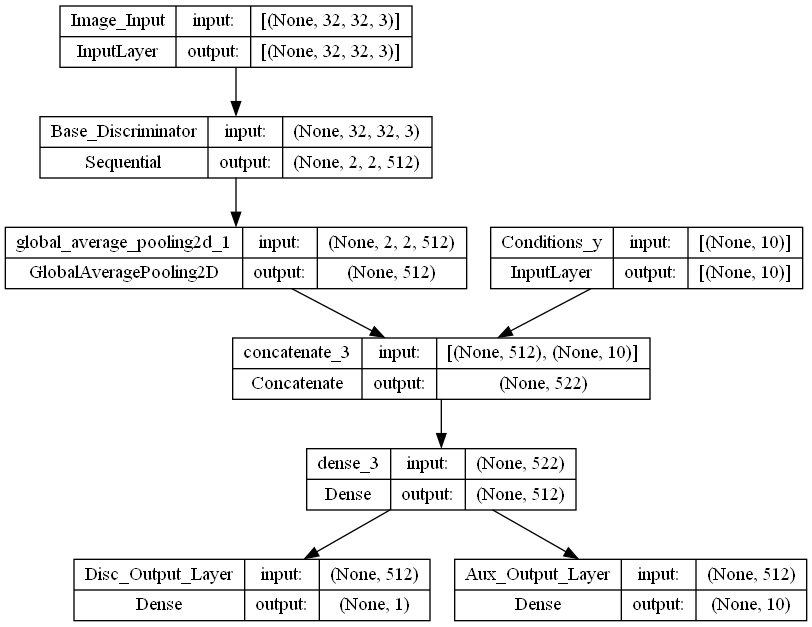

In [ ]:

# visualise model
plot_model(discriminator, show_shapes=True)

In [ ]:
latent_dim = 128
channels = 3
nclasses = 10
img_shape = (32, 32, 3)
discriminator_in_channels = 10 + 3

## Combining Generator and Discriminator

In [ ]:
import keras
class ConditionalGAN(tf.keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(ConditionalGAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.gen_loss_tracker = tf.keras.metrics.Mean(name="generator_loss")
        self.disc_loss_tracker = tf.keras.metrics.Mean(name="discriminator_loss")
        self.d_xy_tracker = tf.keras.metrics.Mean(name='Mean D(x|y)')
        self.d_g_zy_tracker = tf.keras.metrics.Mean(name='Mean D(G(z|y))')
        self.kl = tf.keras.metrics.KLDivergence()

    def compile(self, d_optimizer, g_optimizer, disc_loss_fn, aux_loss_fn):
        super(ConditionalGAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.disc_loss_fn = disc_loss_fn
        self.aux_loss_fn = aux_loss_fn

    def train_step(self, data):
        ### TRAINING DISCRIMINATOR ###
        # Unpack the data.
        real_images, condition = data

        # Sample for latent noise vector z
        batch_size = tf.shape(real_images)[0]
        latent_noise_vector = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Maps the noise latent vector and labels to generate fake images.
        generated_images = self.generator([latent_noise_vector, condition])

        # Combine with real images
        combined_images = tf.concat([generated_images, real_images], axis=0)
        combined_condition = tf.concat([condition, condition], axis=0)

        # Discrimination
        labels = tf.concat(
            [tf.zeros((batch_size, 1)), tf.ones((batch_size, 1))], axis=0
        )

        # Train the discriminator.
        with tf.GradientTape() as tape:
            disc_output, aux_output = self.discriminator([combined_images, combined_condition])
            disc_d_loss = self.disc_loss_fn(labels, disc_output)
            aux_d_loss = self.aux_loss_fn(combined_condition, aux_output)
            d_loss = disc_d_loss + aux_d_loss
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Computing D(x|y)
        d_xy = tf.math.reduce_mean(disc_output)

        ### TRAINING GENRATOR ###
        latent_noise_vector = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Assemble labels that say "all real images".
        misleading_labels = tf.ones((batch_size, 1))

        # Train the Generator
        with tf.GradientTape() as tape:
            fake_images = self.generator([latent_noise_vector, condition])
            disc_output, aux_output = self.discriminator([fake_images, condition])        
            disc_g_loss = self.disc_loss_fn(misleading_labels, disc_output)
            aux_g_loss = self.aux_loss_fn(condition, aux_output)
            g_loss = disc_g_loss + aux_g_loss
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Computing D(G(z|y))
        d_g_zy = tf.math.reduce_mean(disc_output)

        # Monitor loss and metrics.
        self.gen_loss_tracker.update_state(g_loss)
        self.disc_loss_tracker.update_state(d_loss)
        self.d_xy_tracker.update_state(d_xy)
        self.d_g_zy_tracker.update_state(d_g_zy)
        self.kl.update_state(real_images, fake_images)

        return {
            "d_loss": self.disc_loss_tracker.result(),
            "g_loss": self.gen_loss_tracker.result(),
            "D(x|y)": self.d_xy_tracker.result(),
            "D(G(z|y))": self.d_g_zy_tracker.result(),
            "KL Divergence": self.kl.result(),
        }
# Custom callback to display generated images every n epochs and after training
class GANMonitor(keras.callbacks.Callback):
    # class GANMontor
    # - num_img: number of images generated using matplotlib figure
    # - latent_dim: dimensions of noise latent vector passed into the generator
    # - patience: number of epochs to generate images
    # - vmin: minumum scaling factor, a
    # - vmax: maximum scaling factor, b
    # NOTE: only compatible with the GAN class I've set up
    def __init__(self, num_img=20, latent_dim=128, patience=10, vmin=0, vmax=1):
        self.num_img = num_img
        self.latent_dim = latent_dim
        self.patience = patience
        self.vmin = vmin
        self.vmax = vmax

        # making the latent vec
        self.latent_noise_vector = tf.random.normal(shape=(self.num_img, self.latent_dim))
        self.conditions = to_categorical([0, 1, 2, 3, 4, 5, 6, 7, 8, 9,
                                 0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

    # method to generate images and display them as matplotlib figure
    def generate_plot(self):
        # Generate Images
        generated_images = self.model.generator.predict([self.latent_noise_vector, self.conditions])
        # Normalise Image from [vmin, vmax] to [0, 1]
        generated_images -= self.vmin
        generated_images /= (self.vmax - self.vmin)

        # Generate Matplotlib Figure
        row_size = int(np.ceil(self.num_img/5))
        fig = plt.figure(figsize=(10, 2*row_size), tight_layout=True)
        for i in range(self.num_img):
            ax = fig.add_subplot(row_size, 5, i+1)
            ax.imshow(generated_images[i])
            ax.set_title(classes[i%10])
            ax.axis('off')
        plt.show()

    # method to save generator's weights
    def save_weights(self, epoch=None):
        try:
            if epoch != None:
                name='./model/acgan/generator-epoch-{}.h5'.format(epoch)
                print('Generator Checkpoint - {}'.format(name))
                self.model.generator.save_weights(
                    filepath=name,
                    save_format='h5'
                )
        except Exception as e:
            print(e)

    # generate a plot every n epochs
    def on_epoch_begin(self, epoch, logs=None):
        if epoch % self.patience == 0:
            self.generate_plot()
            self.save_weights(epoch)

    # generate a plot after training
    def on_train_end(self, epoch, logs=None):
        self.generate_plot()
        self.save_weights('Full Train')
# List of Callback Functions
callbacks = [
    GANMonitor(num_img=20, latent_dim=128, patience=5, vmin=-1, vmax=1),
]

1/1 [==============================] - 0s 80ms/step


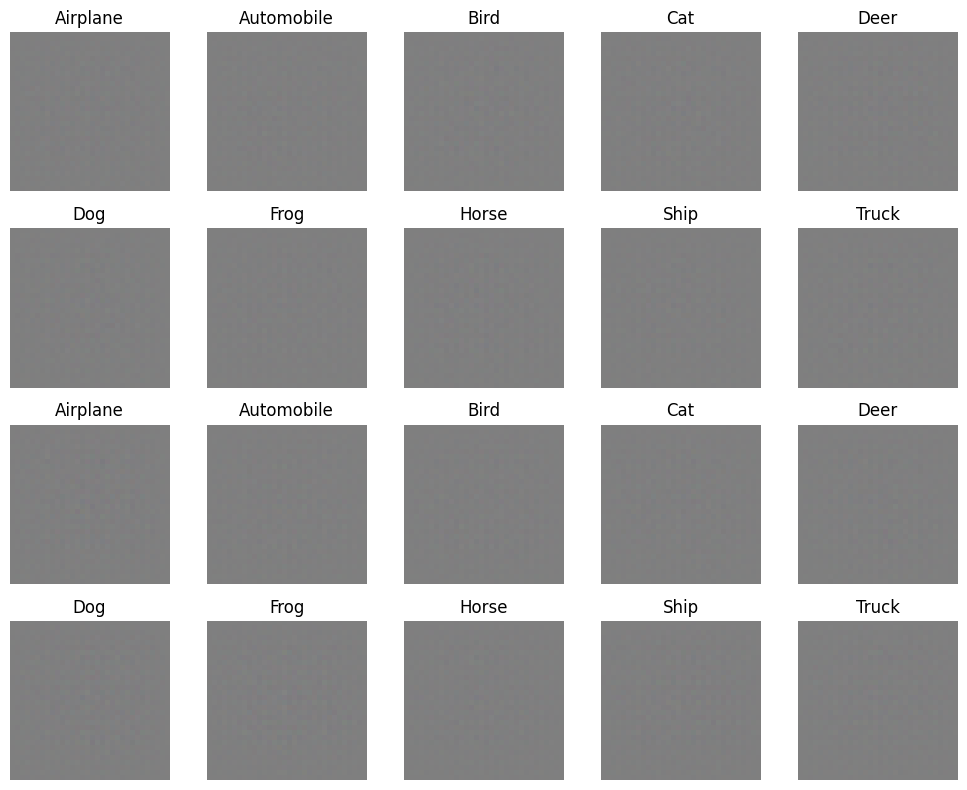

Generator Checkpoint - generator-epoch-0.h5
Epoch 1/100


ValueError: in user code:

    File "c:\Users\Xavier\anaconda3\envs\gpu_env\lib\site-packages\keras\engine\training.py", line 1160, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\Xavier\anaconda3\envs\gpu_env\lib\site-packages\keras\engine\training.py", line 1146, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\Xavier\anaconda3\envs\gpu_env\lib\site-packages\keras\engine\training.py", line 1135, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\Xavier\AppData\Local\Temp\ipykernel_23892\30267721.py", line 31, in train_step
        generated_images = self.generator([latent_noise_vector, condition])
    File "c:\Users\Xavier\anaconda3\envs\gpu_env\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\Xavier\anaconda3\envs\gpu_env\lib\site-packages\keras\engine\input_spec.py", line 277, in assert_input_compatibility
        raise ValueError(

    ValueError: Exception encountered when calling layer "generator" "                 f"(type Functional).
    
    Input 0 of layer "dense_2" is incompatible with the layer: expected axis -1 of input shape to have value 138, but received input with shape (None, 129)
    
    Call arguments received by layer "generator" "                 f"(type Functional):
      • inputs=['tf.Tensor(shape=(None, 128), dtype=float32)', 'tf.Tensor(shape=(None, 1), dtype=uint8)']
      • training=False
      • mask=None


: 

In [ ]:
cond_gan = ConditionalGAN(
    discriminator=discriminator, 
    generator=generator, 
    latent_dim=latent_dim
)
# Compiling with Optimizer and Loss Function
cond_gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5),
    disc_loss_fn=keras.losses.BinaryCrossentropy(),
    aux_loss_fn=keras.losses.CategoricalCrossentropy()
)

# Preparing the Dataset with `tf.data`
batch_size = 64
dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
dataset = dataset.shuffle(buffer_size=1024).batch(batch_size, num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)

# Starting the Train Process
hist = cond_gan.fit(dataset, epochs=100, use_multiprocessing=True, workers=16, callbacks=callbacks)

In [ ]:
hist_df = pd.DataFrame(hist.history)

# using pandas dataframe to plot out learning curve
with plt.style.context('seaborn'):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 8), tight_layout=True)
    hist_df.loc[:, ["d_loss", 'g_loss']].plot(ax=ax1, title=r'Learning Curve of Loss Function CE')
    hist_df.loc[:, ['D(x|y)', 'D(G(z|y))']].plot(ax=ax2, title=r'Learning Curve of Discriminator')
    hist_df.loc[:,'KL Divergence'].plot(ax=ax3, title=r'Learning Curve of Probabilistic Similarity')
    plt.show()

# Trying out with upsampling and BatchNorm


In [ ]:
def build_generator():

        model = Sequential()

        model.add(Dense(128 * 8 * 8, activation="relu", input_dim=latent_dim))
        model.add(Reshape((8, 8, 128)))
        
        model.add(UpSampling2D())#upsamples to 16*16*128
        
        model.add(Conv2D(128, kernel_size=3, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))
        
        model.add(UpSampling2D()) #upsamples to 32*32*128
        
        model.add(Conv2D(64, kernel_size=3, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))
        
        model.add(Conv2D(3, kernel_size=3, padding="same"))
        model.add(Activation("tanh"))

        #outputs an image of 32*32*3

        noise = Input(shape=(latent_dim,))
        img = model(noise)
        model.summary()
        return Model(noise, img)

In [ ]:
plot_model(build_generator())

NameError: name 'latent_dim' is not defined

In [ ]:
def build_discriminator():
        model = Sequential()

        model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=(32,32,3), padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        #no normalization for the first layer 
        
        model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
        model.add(ZeroPadding2D(padding=((0,1),(0,1))))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        
        model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        
        model.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        
        model.add(Flatten())
        model.add(Dense(1, activation='sigmoid'))

        

        img = Input(shape=(32,32,3))
        validity = model(img)
        model.summary()
        return Model(img, validity)

In [ ]:
discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy',
            optimizer=Adam(0.0002,0.5),
            metrics=['accuracy'])

# Build the generator
generator = build_generator()

# The generator takes noise as input and generates imgs
z = Input(shape=(latent_dim,))
img = generator(z)

# For the combined model we will only train the generator
discriminator.trainable = False

# The discriminator takes generated images as input and determines validity
valid = discriminator(img)

# The combined model  (stacked generator and discriminator)
# Trains the generator to fool the discriminator
combined = Model(z, valid)
combined.compile(loss='binary_crossentropy', optimizer=Adam(0.0002,0.5))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 16, 16, 32)        896       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 16, 16, 32)        0         
                                                                 
 dropout (Dropout)           (None, 16, 16, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 64)          18496     
                                                                 
 zero_padding2d (ZeroPadding  (None, 9, 9, 64)         0         
 2D)                                                             
                                                                 
 batch_normalization (BatchN  (None, 9, 9, 64)         256       
 ormalization)                                          

NameError: name 'latent_dim' is not defined

>mode collapsed occured

# Trying with data augmentation